**Quantum Kalman Filter with Variational Quantum Regressor (VQR)**

This notebook explores the implementation of a hybrid quantum-classical Kalman Filter framework using a Variational Quantum Regressor (VQR). The aim is to enhance state estimation processes for dynamic systems by leveraging the power of quantum computing.



In [ ]:
!pip install qiskit
!pip install qiskit-machine-learning --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.6/231.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 3.9 MB/s eta 0:00:00


This section imports the required libraries and frameworks for implementing the Quantum Kalman Filter and Variational Quantum Regressor (VQR). It includes tools for both quantum and classical computations, as well as visualization.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt
#plt.style.use( 'dark_background' )

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
#from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
#from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.optimizers import COBYLA, L_BFGS_B
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit.primitives import StatevectorEstimator as Estimator
from IPython.display import clear_output

This section demonstrates the simulation of noisy measurements and the implementation of a hybrid KalmanNet architecture using PyTorch. The goal is to integrate a neural network with a Kalman filter to enhance state estimation accuracy.

In [ ]:
# Simulate some noisy measurements
np.random.seed(42)
true_states = np.linspace(0, 10, 100) + 0.5 * np.random.normal(size=100)
measurements = true_states + 1.0 * np.random.normal(size=100)

class KalmanNet(nn.Module):
    def __init__(self):
        super(KalmanNet, self).__init__()

        # Neural network for learning dynamics
        self.neural_net = nn.Sequential(
            nn.Linear(1, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 1)
        )

        # Kalman filter parameters
        self.transition_matrix = nn.Parameter(torch.eye(1))
        self.observation_matrix = nn.Parameter(torch.eye(1))
        self.process_noise_cov = nn.Parameter(torch.eye(1) * 0.01)
        self.measurement_noise_cov = nn.Parameter(torch.tensor(1.0))
        self.state_cov = nn.Parameter(torch.eye(1))
        self.initial_state = nn.Parameter(torch.zeros(1))

    def forward(self, inputs):
        # Neural network prediction of the next state
        predicted_state = self.neural_net(inputs)
        # Kalman filter update
        state_prediction = torch.matmul(self.transition_matrix, self.initial_state)
        state_cov_prediction = torch.matmul(torch.matmul(self.transition_matrix, self.state_cov),
                                            self.transition_matrix.t()) + self.process_noise_cov

        # Reshape input to match matrix multiplication dimensions
        inputs = inputs.view(1, -1)

        kalman_gain = torch.matmul(torch.matmul(state_cov_prediction, self.observation_matrix.t()),
                                   torch.inverse(torch.matmul(torch.matmul(self.observation_matrix, state_cov_prediction),
                                                            self.observation_matrix.t()) + self.measurement_noise_cov))

        # Update initial_state with appropriate dimensions
        updated_initial_state = state_prediction + torch.matmul(kalman_gain, inputs - torch.matmul(self.observation_matrix, state_prediction))
        self.initial_state = nn.Parameter(updated_initial_state)  # Convert to nn.Parameter

        # Update state_cov with appropriate dimensions
        self.state_cov = nn.Parameter(state_cov_prediction - torch.matmul(kalman_gain, torch.matmul(self.observation_matrix, state_cov_prediction)))

        # Update neural network prediction using Kalman filter updated state
        predicted_state = self.neural_net(updated_initial_state.view(-1, 1))

        return predicted_state

kalman_net_model = KalmanNet()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(kalman_net_model.parameters(), lr=0.001)

# Convert data to PyTorch tensors
inputs = torch.tensor(measurements, dtype=torch.float32).view(-1,1)
targets = torch.tensor(true_states, dtype=torch.float32).view(-1, 1)

# Training loop
num_epochs = 10000
for epoch in range(num_epochs):
    # Forward pass
    outputs = kalman_net_model(inputs)
    loss = criterion(outputs, targets)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/10000], Loss: 0.7935
Epoch [200/10000], Loss: 0.7869
Epoch [300/10000], Loss: 0.7857
Epoch [400/10000], Loss: 0.7847
Epoch [500/10000], Loss: 0.7837
Epoch [600/10000], Loss: 0.7826
Epoch [700/10000], Loss: 0.7813
Epoch [800/10000], Loss: 0.7797
Epoch [900/10000], Loss: 0.7774
Epoch [1000/10000], Loss: 0.7743
Epoch [1100/10000], Loss: 0.7707
Epoch [1200/10000], Loss: 0.7671
Epoch [1300/10000], Loss: 0.7637
Epoch [1400/10000], Loss: 0.7601
Epoch [1500/10000], Loss: 0.7562
Epoch [1600/10000], Loss: 0.7518
Epoch [1700/10000], Loss: 0.7472
Epoch [1800/10000], Loss: 0.7416
Epoch [1900/10000], Loss: 0.7338
Epoch [2000/10000], Loss: 0.7270
Epoch [2100/10000], Loss: 0.7213
Epoch [2200/10000], Loss: 0.7169
Epoch [2300/10000], Loss: 0.7126
Epoch [2400/10000], Loss: 0.7024
Epoch [2500/10000], Loss: 0.7027
Epoch [2600/10000], Loss: 0.6886
Epoch [2700/10000], Loss: 0.6955
Epoch [2800/10000], Loss: 0.6909
Epoch [2900/10000], Loss: 0.6869
Epoch [3000/10000], Loss: 0.6825
Epoch [3100/10000],

This section tests the trained KalmanNet model and visualizes its performance by comparing the true states, noisy measurements, and estimated states.

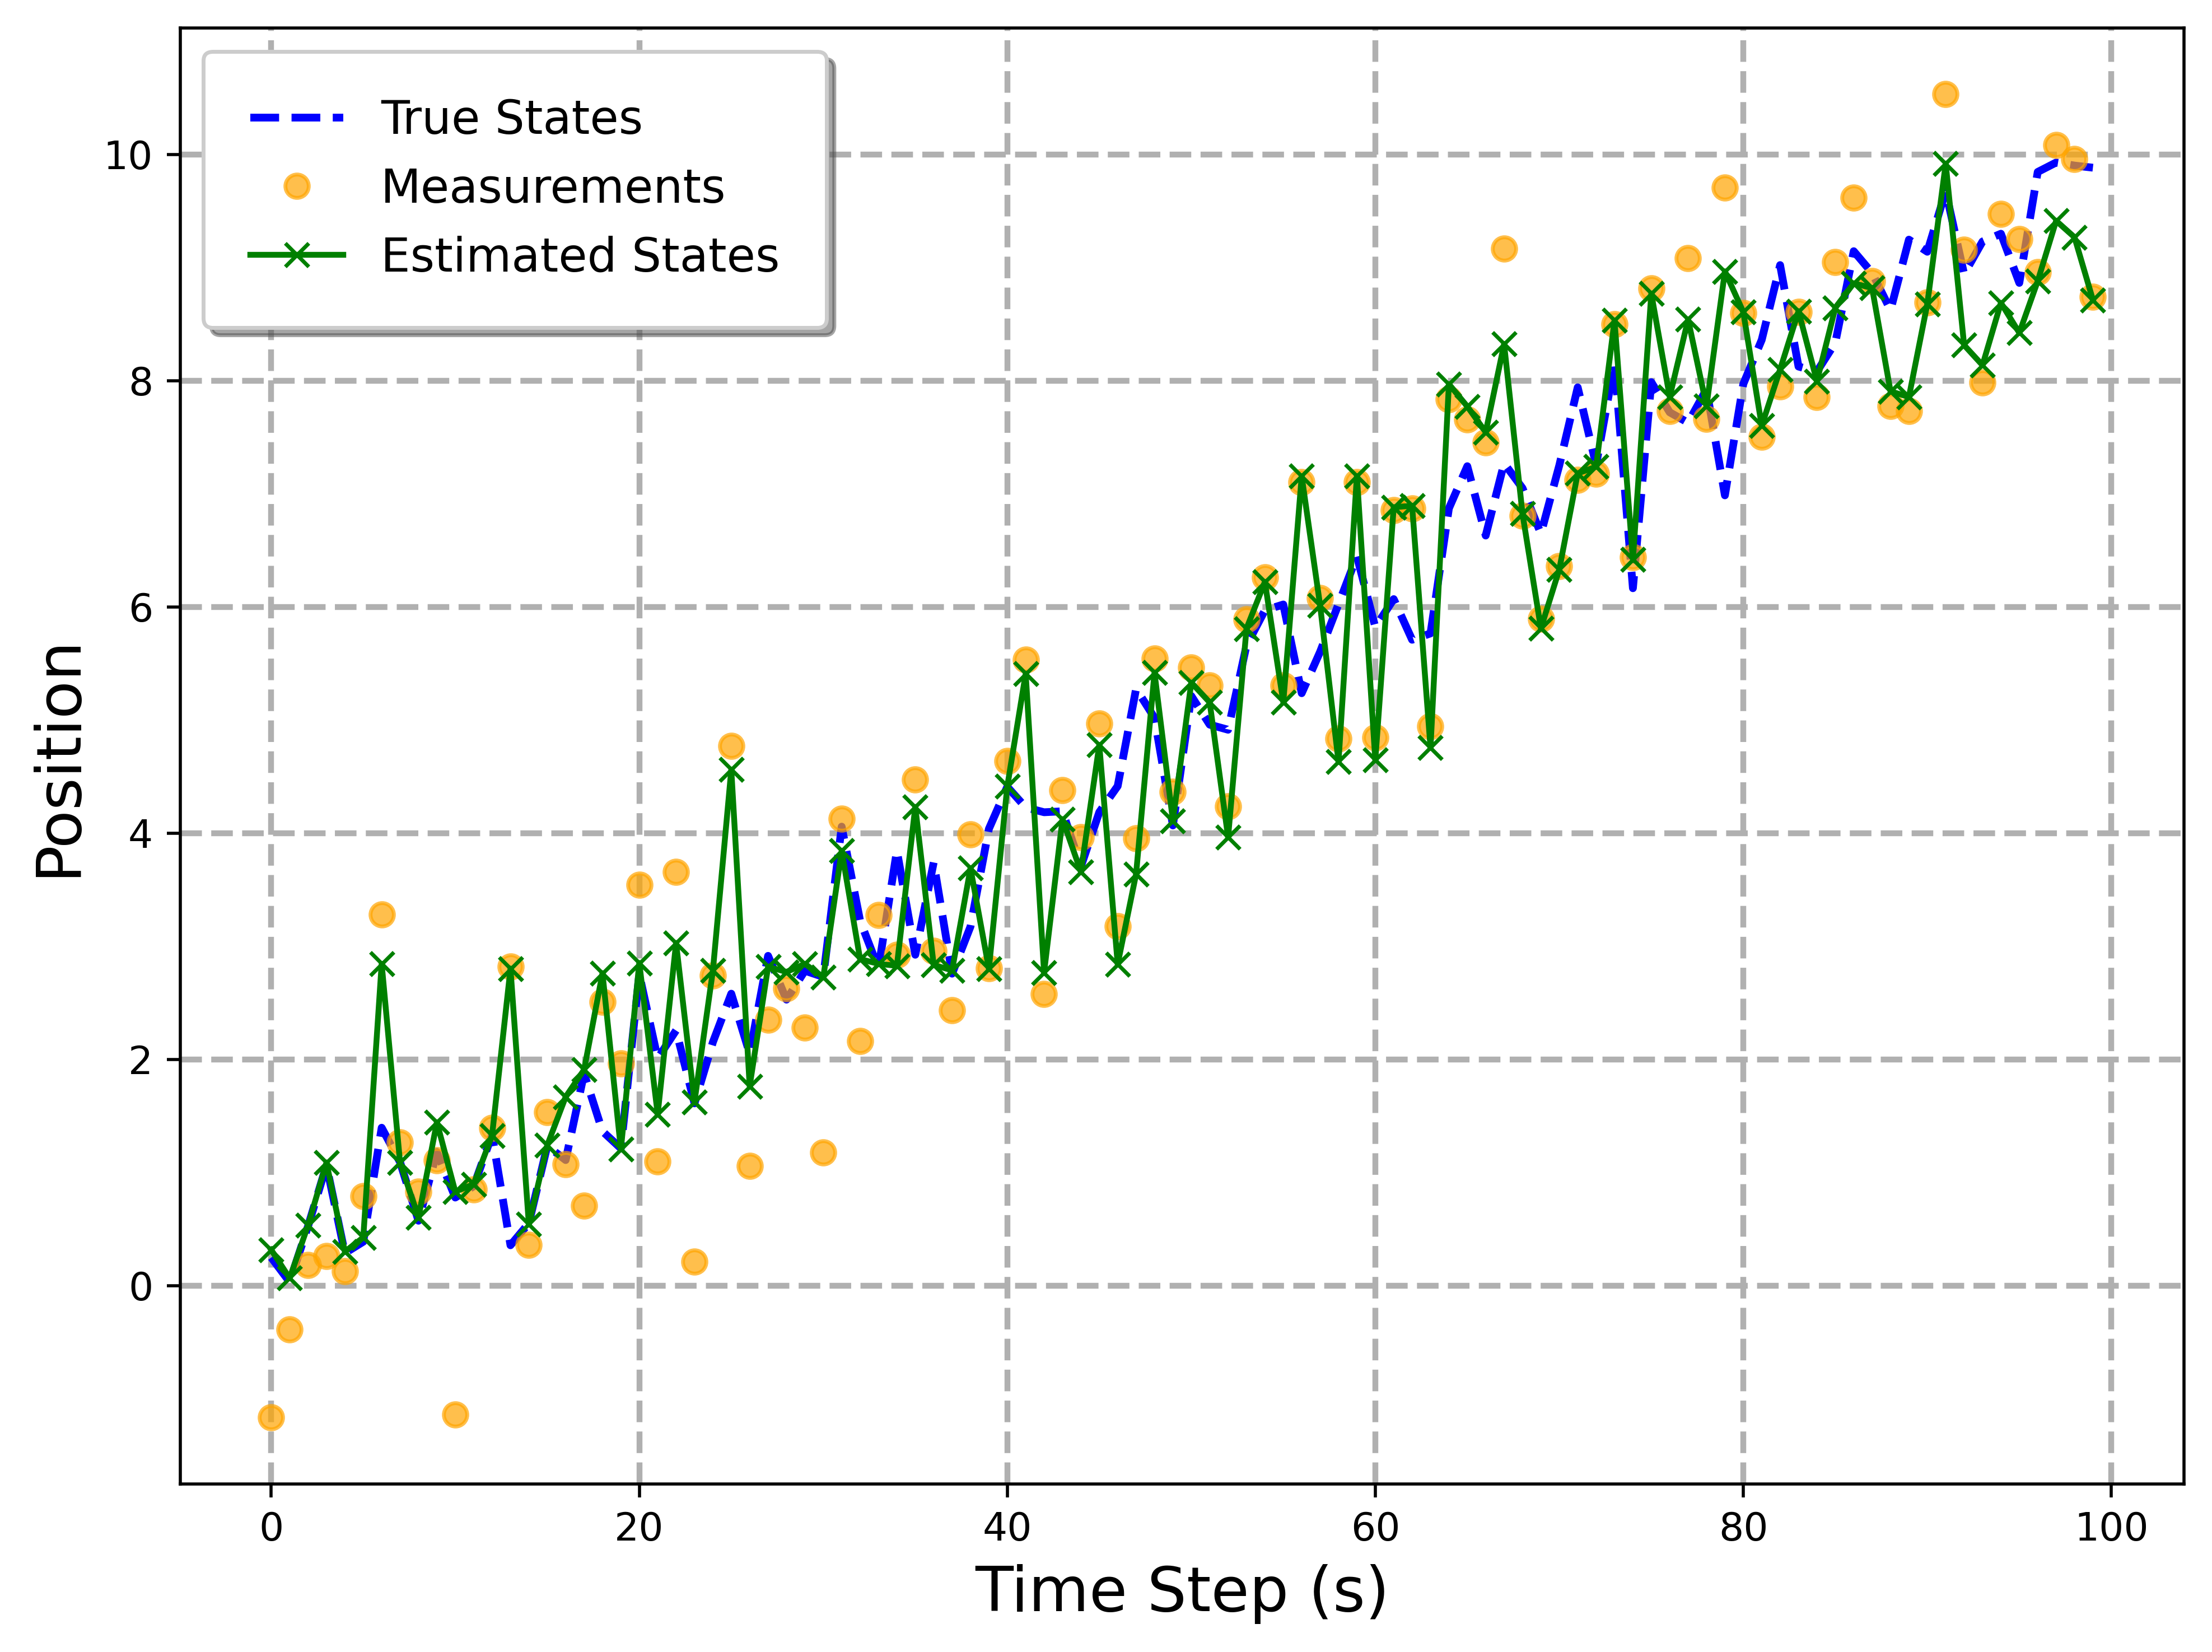

In [ ]:
# Test the model
kalman_net_model.eval()
estimated_states = kalman_net_model(inputs).detach().numpy()

# Plot the results
plt.figure(figsize=(8, 6), dpi=500)
plt.plot(true_states, label='True States', linestyle='--', linewidth=2, color='blue')  # Bold lines
plt.plot(measurements, label='Measurements', marker='o', linestyle='None', color='orange', alpha=0.7)  # Transparency for clarity
plt.plot(estimated_states, label='Estimated States', marker='x', linestyle='-', linewidth=1.5, color='green')
plt.grid(True, linestyle='--', linewidth=1.5, alpha=1)  # Dotted grid lines
#plt.title('KalmanNet for State Estimation', fontsize=16, fontweight='bold')
plt.xlabel('Time Step (s)', fontsize=16)
plt.ylabel('Position', fontsize=16)
plt.legend(fontsize=12, loc='best', frameon=True, shadow=True, borderpad=1)
plt.tight_layout()
plt.show()

This section integrates physics-based modeling with machine learning by using a hybrid RK4 numerical solver and a Physics-Informed Neural Network (PINN) to simulate and predict satellite orbits in a two-body problem.

[[ 6.82800000e+03  0.00000000e+00  0.00000000e+00  0.00000000e+00
   7.64050612e+00  0.00000000e+00]
 [ 6.78529602e+03  7.62456082e+02  0.00000000e+00 -8.53187577e-01
   7.59272053e+00  0.00000000e+00]
 [ 6.65771841e+03  1.51537499e+03  0.00000000e+00 -1.69570318e+00
   7.44996165e+00  0.00000000e+00]
 [ 6.44686296e+03  2.24933886e+03  0.00000000e+00 -2.51700830e+00
   7.21401514e+00  0.00000000e+00]
 [ 6.15536713e+03  2.95516692e+03  0.00000000e+00 -3.30682973e+00
   6.88783226e+00  0.00000000e+00]
 [ 5.78687706e+03  3.62403034e+03  0.00000000e+00 -4.05528805e+00
   6.47549297e+00  0.00000000e+00]
 [ 5.34600197e+03  4.24756263e+03  0.00000000e+00 -4.75302123e+00
   5.98215490e+00  0.00000000e+00]
 [ 4.83825651e+03  4.81796432e+03  0.00000000e+00 -5.39130167e+00
   5.41398884e+00  0.00000000e+00]
 [ 4.26999176e+03  5.32810052e+03  0.00000000e+00 -5.96214543e+00
   4.77810155e+00  0.00000000e+00]
 [ 3.64831582e+03  5.77159015e+03  0.00000000e+00 -6.45841204e+00
   4.08244691e+00  0.0000

<ipython-input-9-a39aff843068>:124: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


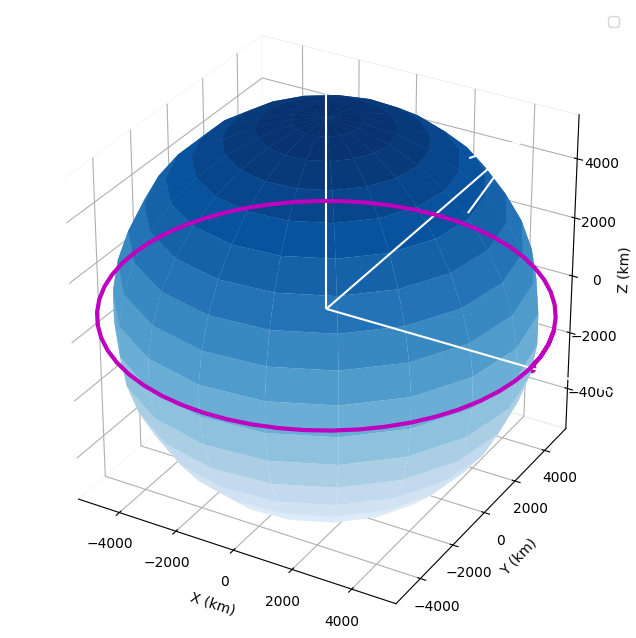

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Step 0, Loss: 7768959.495568541
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━

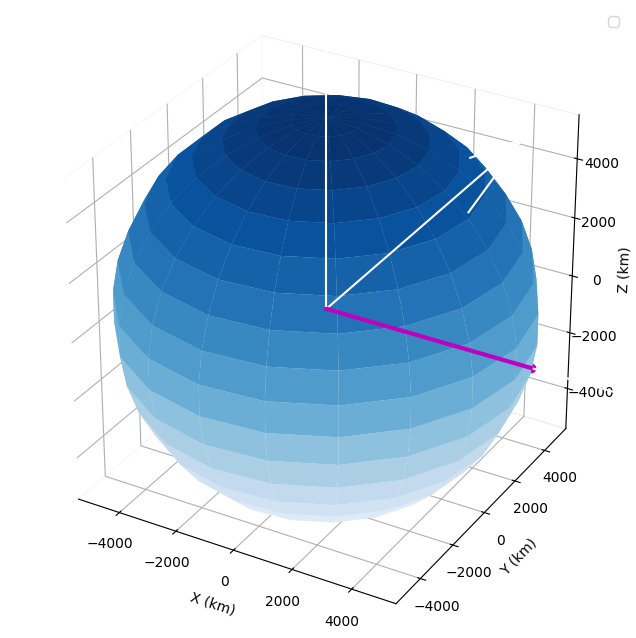

In [ ]:
earth_radius = 6378.0 # km
earth_mu     = 3.9860043543609598E+05 # km^3 / s^2

def rk4_step( f, t, y, h ):
	'''
	Calculate one RK4 step
	'''
	k1 = f( t, y )
	k2 = f( t + 0.5 * h, y + 0.5 * k1 * h )
	k3 = f( t + 0.5 * h, y + 0.5 * k2 * h )
	k4 = f( t +       h, y +       k3 * h )

	return y + h / 6.0 * ( k1 + 2 * k2 + 2 * k3 + k4 )


def two_body_ode( t, state ):
	'''
	Newtons Universal Law of Gravitation
	'''
	r = state[ :3 ]
	a = -earth_mu * r / np.linalg.norm( r ) ** 3

	return np.array( [ state[ 3 ], state[ 4 ], state[ 5 ],
			 a[ 0 ], a[ 1 ], a[ 2 ] ] )


def plot_orbits( rs, args ):
	_args = {
		'figsize'      : ( 10, 8 ),
		'labels'       : [ '' ] * len( rs ),
		'colors'       : [ 'm', 'c', 'r', 'C3' ],
		'traj_lws'     : 3,
		'dist_unit'    : 'km',
		'groundtracks' : False,
		'cb_radius'    : 6378.0,
		'cb_SOI'       : None,
		'cb_SOI_color' : 'c',
		'cb_SOI_alpha' : 0.7,
		'cb_axes'      : True,
		'cb_axes_mag'  : 2,
		'cb_cmap'      : 'Blues',
		'cb_axes_color': 'w',
		'axes_mag'     : 0.8,
		'axes_custom'  : None,
		'title'        : 'Trajectories',
		'legend'       : True,
		'axes_no_fill' : True,
		'hide_axes'    : False,
		'azimuth'      : False,
		'elevation'    : False,
		'show'         : False,
		'filename'     : False,
		'dpi'          : 300
	}
	for key in args.keys():
		_args[ key ] = args[ key ]

	fig = plt.figure( figsize = _args[ 'figsize' ] )
	ax  = fig.add_subplot( 111, projection = '3d'  )

	max_val = 0
	n       = 0

	for r in rs:
		ax.plot( r[ :, 0 ], r[ :, 1 ], r[ : , 2 ],
			color = _args[ 'colors' ][ n ], label = _args[ 'labels' ][ n ],
			zorder = 10, linewidth = _args[ 'traj_lws' ] )
		ax.plot( [ r[ 0, 0 ] ], [ r[ 0 , 1 ] ], [ r[ 0, 2 ] ], 'o',
			color = _args[ 'colors' ][ n ] )

		if _args[ 'groundtracks' ]:
			rg  = r[ : ] / np.linalg.norm( r, axis = 1 ).reshape( ( r.shape[ 0 ], 1 ) )
			rg *= _args[ 'cb_radius' ]

			ax.plot( rg[ :, 0 ], rg[ :, 1 ], rg[ :, 2 ], cs[ n ], zorder = 10 )
			ax.plot( [ rg[ 0, 0 ] ], [ rg[ 0, 1 ] ], [ rg[ 0, 2 ] ], cs[ n ] + 'o', zorder = 10 )

		max_val = max( [ r.max(), max_val ] )
		n += 1

	_u, _v = np.mgrid[ 0:2*np.pi:20j, 0:np.pi:20j ]
	_x     = _args[ 'cb_radius' ] * np.cos( _u ) * np.sin( _v )
	_y     = _args[ 'cb_radius' ] * np.sin( _u ) * np.sin( _v )
	_z     = _args[ 'cb_radius' ] * np.cos( _v )
	ax.plot_surface( _x, _y, _z, cmap = _args[ 'cb_cmap' ], zorder = 1 )

	if _args[ 'cb_axes' ]:
		l       = _args[ 'cb_radius' ] * _args[ 'cb_axes_mag' ]
		x, y, z = [ [ 0, 0, 0 ], [ 0, 0, 0  ], [ 0, 0, 0 ] ]
		u, v, w = [ [ l, 0, 0 ], [ 0, l, 0 ], [ 0, 0, l ] ]
		ax.quiver( x, y, z, u, v, w, color = _args[ 'cb_axes_color' ] )

	xlabel = 'X (%s)' % _args[ 'dist_unit' ]
	ylabel = 'Y (%s)' % _args[ 'dist_unit' ]
	zlabel = 'Z (%s)' % _args[ 'dist_unit' ]

	if _args[ 'axes_custom' ] is not None:
		max_val = _args[ 'axes_custom' ]
	else:
		max_val *= _args[ 'axes_mag' ]

	ax.set_xlim( [ -max_val, max_val ] )
	ax.set_ylim( [ -max_val, max_val ] )
	ax.set_zlim( [ -max_val, max_val ] )
	ax.set_xlabel( xlabel )
	ax.set_ylabel( ylabel )
	ax.set_zlabel( zlabel )
	ax.set_box_aspect( [ 1, 1, 1 ] )
	ax.set_aspect( 'auto' )

	if _args[ 'azimuth' ] is not False:
		ax.view_init( elev = _args[ 'elevation' ],
					  azim = _args[ 'azimuth'   ] )

	if _args[ 'axes_no_fill' ]:
		ax.xaxis.pane.fill = False
		ax.yaxis.pane.fill = False
		ax.zaxis.pane.fill = False

	if _args[ 'hide_axes' ]:
		ax.set_axis_off()

	if _args[ 'legend' ]:
		plt.legend()

	if _args[ 'filename' ]:
		plt.savefig( _args[ 'filename' ], dpi = _args[ 'dpi' ] )
		print( 'Saved', _args[ 'filename' ] )

	if _args[ 'show' ]:
		plt.show()

	plt.close()


if __name__ == '__main__':
	r0_norm     = earth_radius + 450.0             # km
	v0_norm     = ( earth_mu / r0_norm ) ** 0.5    # km / s
	statei      = [ r0_norm, 0, 0, 0, v0_norm, 0 ]
	tspan       = 100.0 * 60.0                     # seconds
	dt          = 100.0                            # seconds
	steps       = int( tspan / dt )
	ets         = np.zeros( ( steps, 1 ) )
	states      = np.zeros( ( steps, 6 ) )
	states[ 0 ] = statei

	for step in range( steps - 1 ):
		states[ step + 1 ] = rk4_step(
			two_body_ode, ets[ step ], states[ step ], dt )

	print( states )
	plot_orbits( [ states ], { 'show': True } )

if __name__ == '__main__':
    # Define parameters
    tspan = 100.0 * 60.0  # seconds
    dt = 100.0  # Time step
    steps = int(tspan / dt)

    # Define the PINN architecture
    model = tf.keras.Sequential([
        layers.Dense(128, activation='tanh', input_shape=(6,)),
        layers.Dense(128, activation='tanh'),
        layers.Dense(128, activation='tanh'),
        layers.Dense(6)  # Output size should match the state variables (3 positions + 3 velocities)
    ])

    # Loss function for the PINN
    def physics_loss(ys_true, ys_pred):
        ys_pred = tf.cast(ys_pred, dtype=tf.float64)  # Convert ys_pred to float64
        return tf.reduce_mean(tf.square(ys_true - ys_pred))

    optimizer = tf.keras.optimizers.Adam()

    @tf.function
    def train_step(inputs, targets):
        with tf.GradientTape() as tape:
            predictions = model(inputs)
            loss = physics_loss(targets, predictions)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss

    # Integrate PINN training with RK4 solution
    states = np.zeros((steps, 6))
    state = np.array([earth_radius + 450.0, 0, 0, 0, (earth_mu / (earth_radius + 450.0)) ** 0.5, 0])

    for step in range(steps):
        # RK4 step
        states[step] = state
        state = rk4_step(two_body_ode, step * dt, state, dt)

        # Train PINN with the current state as input and RK4-predicted state as target
        loss = train_step(np.array([state]), np.array([states[step]]))
        if step % 100 == 0:
            print(f"Step {step}, Loss: {loss.numpy()}")

    # Generate predictions using the trained model
    predicted_states = [states[0]]

    for i in range(1, steps):
        predicted_state = model.predict(np.array([predicted_states[i - 1]]))
        predicted_states.append(predicted_state[0])

    predicted_states = np.array(predicted_states)

    # Plot the predicted states
    plot_orbits([predicted_states], {'show': True})

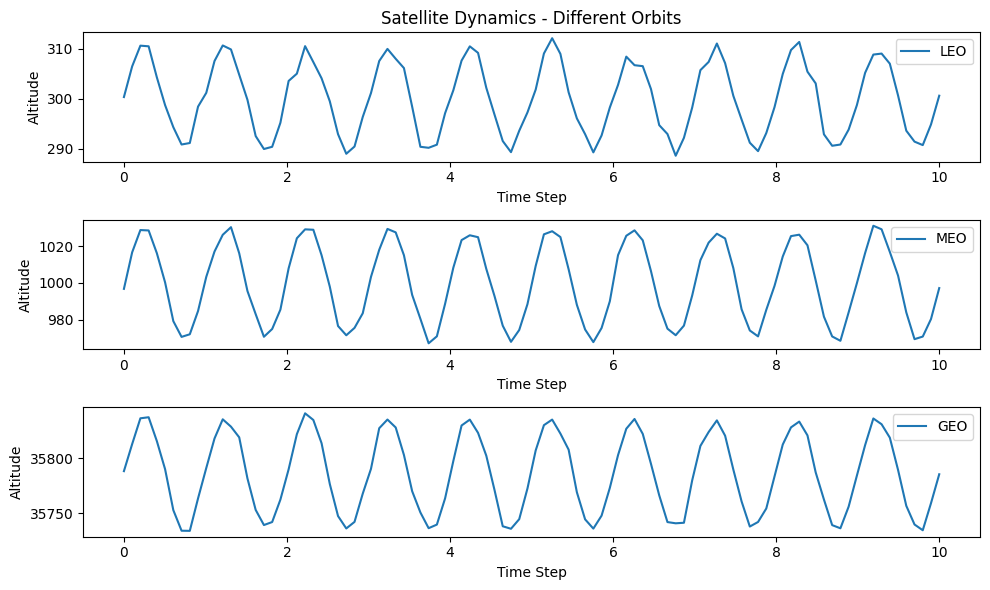

In [ ]:
# LEO satellite dynamics
time_LEO = np.linspace(0, 10, 100)
altitude_LEO = 300 + 10 * np.sin(2 * np.pi * time_LEO) + 1.0 * np.random.normal(size=100)
LEO_measurements = altitude_LEO + 1.0 * np.random.normal(size=100)

# MEO satellite dynamics
time_MEO = np.linspace(0, 10, 100)
altitude_MEO = 1000 + 30 * np.sin(2 * np.pi * time_MEO) + 2.0 * np.random.normal(size=100)
MEO_measurements = altitude_MEO + 1.0 * np.random.normal(size=100)

# GEO satellite dynamics
time_GEO = np.linspace(0, 10, 100)
altitude_GEO = 35786 + 50 * np.sin(2 * np.pi * time_GEO) + 3.0 * np.random.normal(size=100)
GEO_measurements = altitude_GEO + 1.0 * np.random.normal(size=100)

# Plot the datasets
plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.plot(time_LEO, altitude_LEO, label='LEO')
plt.title('Satellite Dynamics - Different Orbits')
plt.xlabel('Time Step')
plt.ylabel('Altitude')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time_MEO, altitude_MEO, label='MEO')
plt.xlabel('Time Step')
plt.ylabel('Altitude')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(time_GEO, altitude_GEO, label='GEO')
plt.xlabel('Time Step')
plt.ylabel('Altitude')
plt.legend()

plt.tight_layout()
plt.show()

The subsequent sections train the KalmanNet model to estimate the altitude dynamics of a satellite in LEO (Low Earth Orbit), MEO (Medium Earth Orbit) and GEO (Geostationary equatorial orbit) using noisy measurements as inputs and true altitudes as targets.

In [ ]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(kalman_net_model.parameters(), lr=0.001)

# Convert data to PyTorch tensors
inputs = torch.tensor(LEO_measurements, dtype=torch.float32).view(-1,1)
targets = torch.tensor(altitude_LEO, dtype=torch.float32).view(-1, 1)

# Training loop
num_epochs = 10000
for epoch in range(num_epochs):
    # Forward pass
    outputs = kalman_net_model(inputs)
    loss = criterion(outputs, targets)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/10000], Loss: 1.6544
Epoch [200/10000], Loss: 0.7595
Epoch [300/10000], Loss: 0.7595
Epoch [400/10000], Loss: 0.7595
Epoch [500/10000], Loss: 0.7595
Epoch [600/10000], Loss: 0.7595
Epoch [700/10000], Loss: 0.7595
Epoch [800/10000], Loss: 0.7595
Epoch [900/10000], Loss: 0.7595
Epoch [1000/10000], Loss: 0.7595
Epoch [1100/10000], Loss: 0.7595
Epoch [1200/10000], Loss: 0.7595
Epoch [1300/10000], Loss: 0.7595
Epoch [1400/10000], Loss: 0.7595
Epoch [1500/10000], Loss: 0.7595
Epoch [1600/10000], Loss: 0.7595
Epoch [1700/10000], Loss: 0.7595
Epoch [1800/10000], Loss: 0.7595
Epoch [1900/10000], Loss: 0.7595
Epoch [2000/10000], Loss: 0.7595
Epoch [2100/10000], Loss: 0.7595
Epoch [2200/10000], Loss: 0.7595
Epoch [2300/10000], Loss: 0.7595
Epoch [2400/10000], Loss: 0.7595
Epoch [2500/10000], Loss: 0.7595
Epoch [2600/10000], Loss: 0.7594
Epoch [2700/10000], Loss: 0.7594
Epoch [2800/10000], Loss: 0.7594
Epoch [2900/10000], Loss: 0.7594
Epoch [3000/10000], Loss: 0.7594
Epoch [3100/10000],

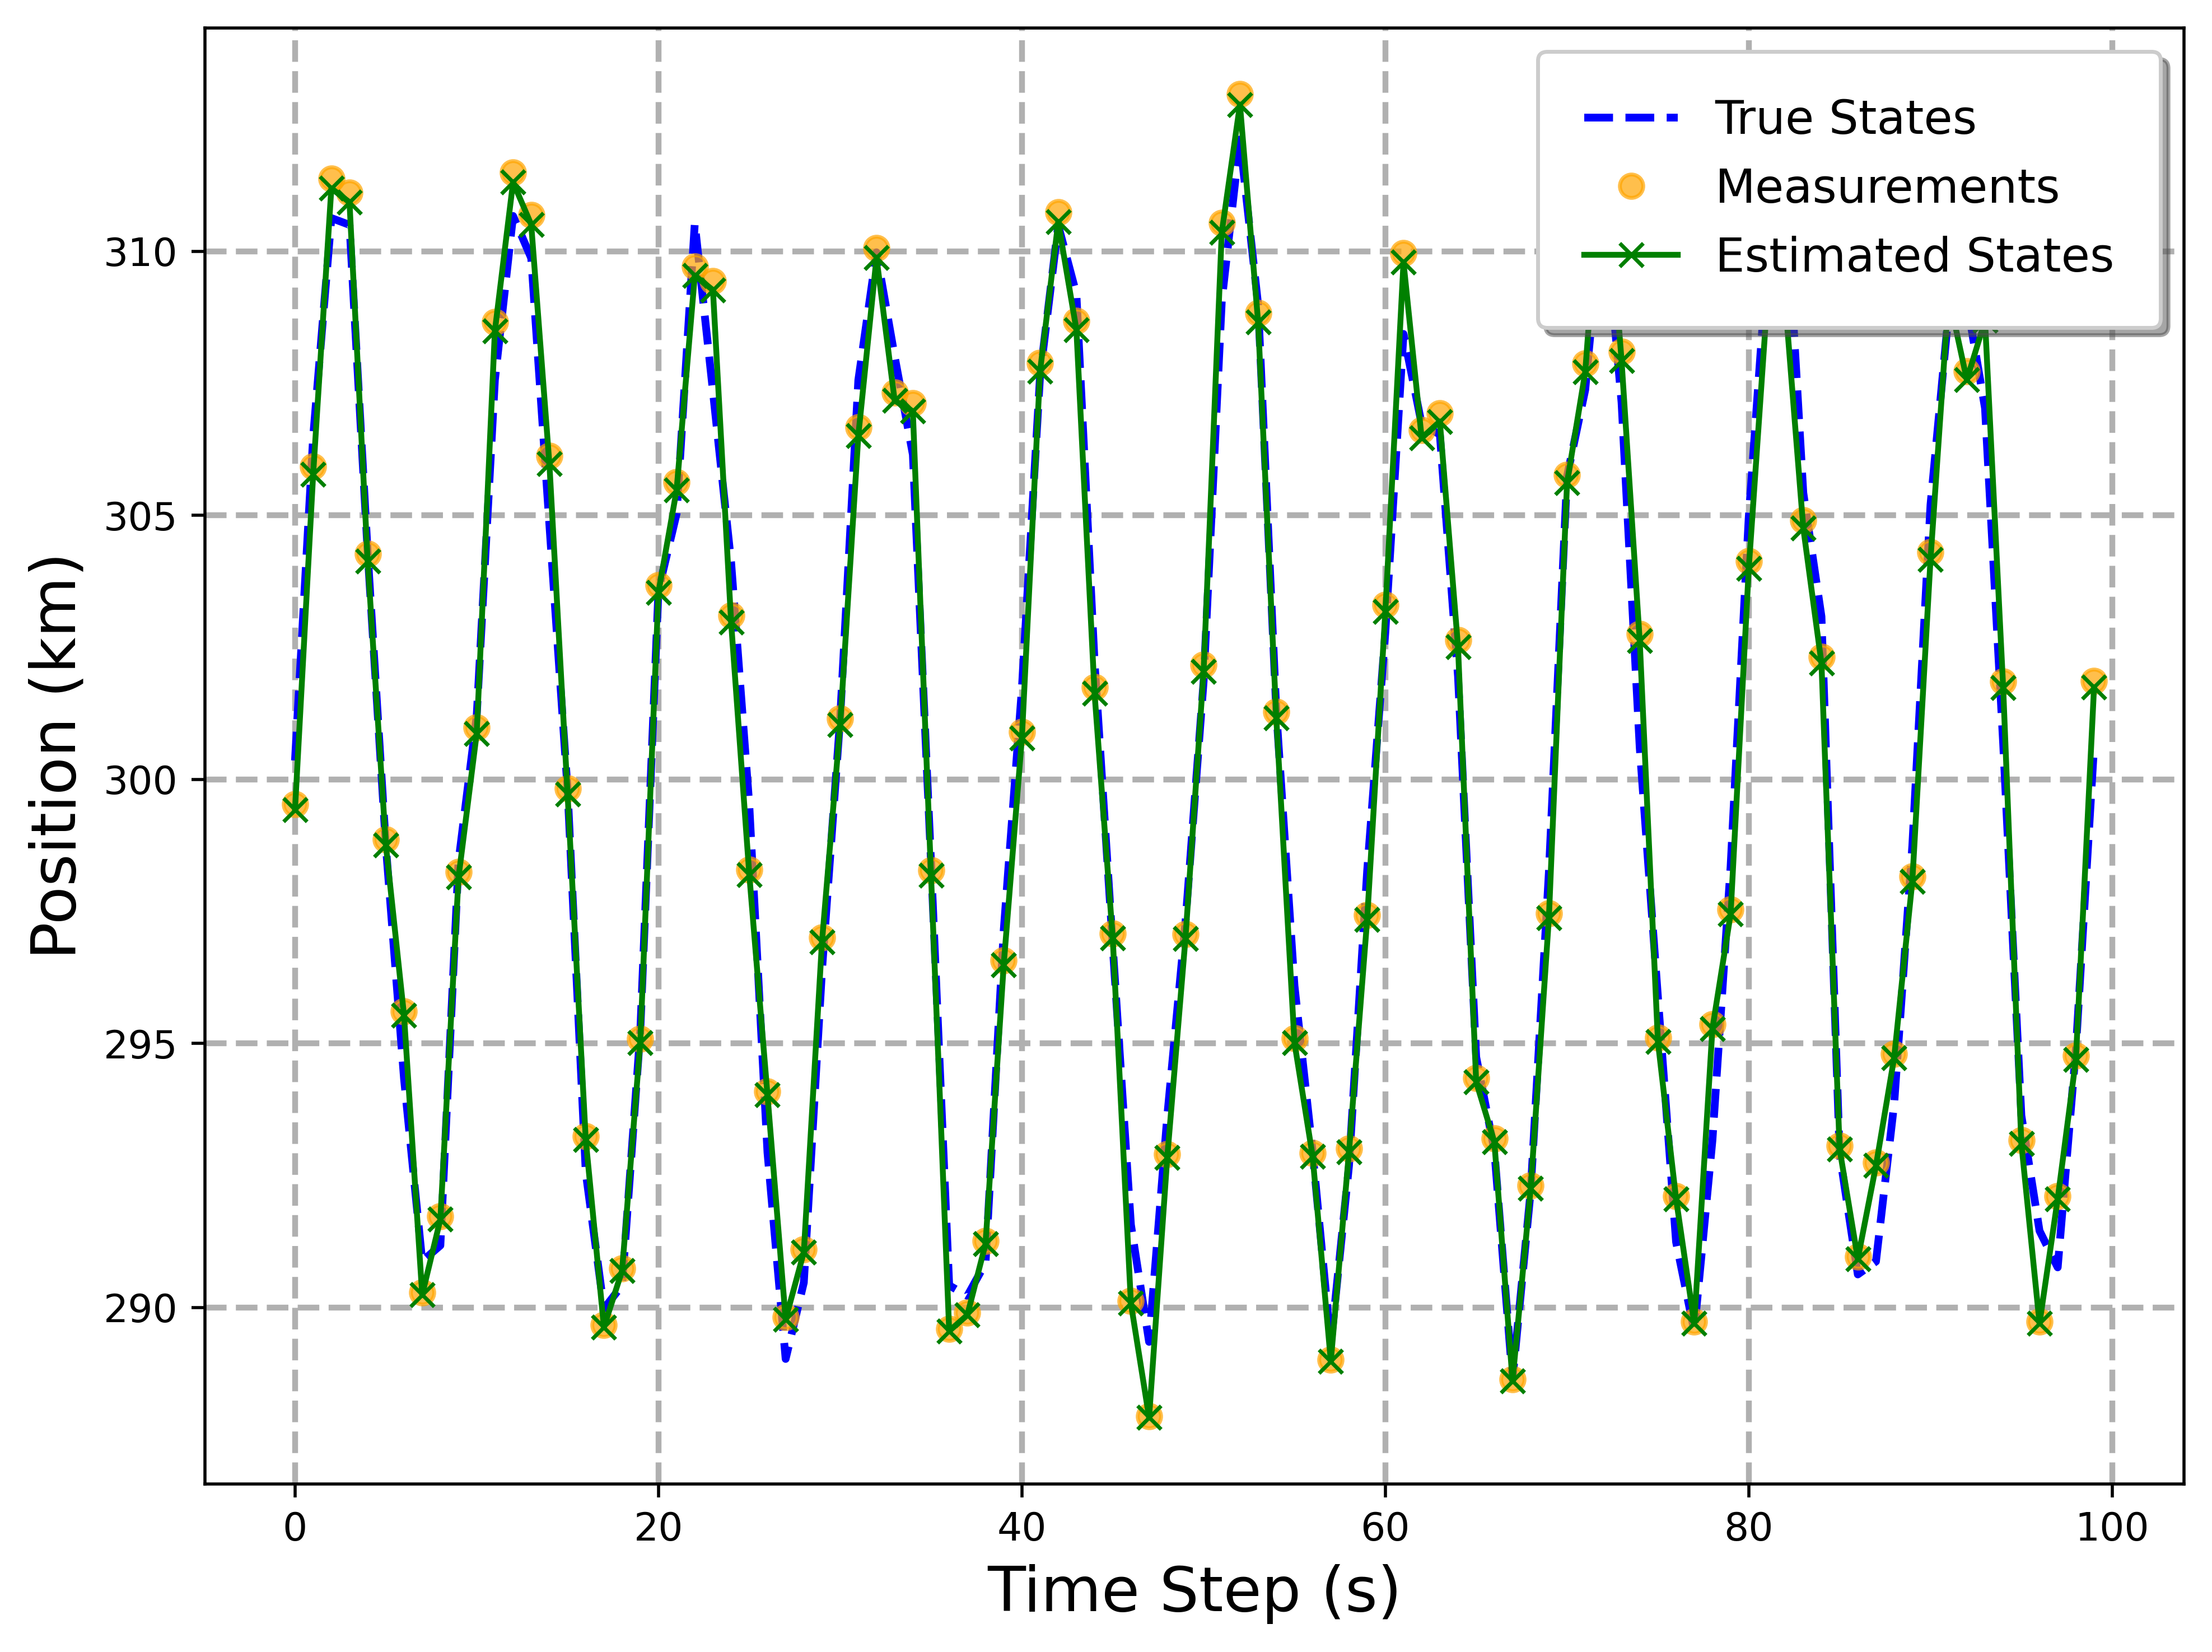

In [ ]:
# Test the model
kalman_net_model.eval()
estimated_states = kalman_net_model(inputs).detach().numpy()

# Plot the results
plt.figure(figsize=(8, 6), dpi=500)
plt.plot(altitude_LEO, label='True States', linestyle='--', linewidth=2, color='blue')  # Bold lines
plt.plot(LEO_measurements, label='Measurements', marker='o', linestyle='None', color='orange', alpha=0.7)  # Transparency for clarity
plt.plot(estimated_states, label='Estimated States', marker='x', linestyle='-', linewidth=1.5, color='green')
plt.grid(True, linestyle='--', linewidth=1.5, alpha=1)  # Dotted grid lines
#plt.title('KalmanNet for State Estimation for LEO satellite', fontsize=16, fontweight='bold')
plt.xlabel('Time Step (s)', fontsize=16)
plt.ylabel('Position (km)', fontsize=16)
plt.legend(fontsize=12, loc='best', frameon=True, shadow=True, borderpad=1)
plt.tight_layout()
plt.show()

In [ ]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(kalman_net_model.parameters(), lr=0.001)

# Convert data to PyTorch tensors
inputs = torch.tensor(MEO_measurements, dtype=torch.float32).view(-1,1)
targets = torch.tensor(altitude_MEO, dtype=torch.float32).view(-1, 1)

# Training loop
num_epochs = 10000
for epoch in range(num_epochs):
    # Forward pass
    outputs = kalman_net_model(inputs)
    loss = criterion(outputs, targets)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/10000], Loss: 2.5971
Epoch [200/10000], Loss: 0.8267
Epoch [300/10000], Loss: 0.8267
Epoch [400/10000], Loss: 0.8267
Epoch [500/10000], Loss: 0.8267
Epoch [600/10000], Loss: 0.8267
Epoch [700/10000], Loss: 0.8267
Epoch [800/10000], Loss: 0.8267
Epoch [900/10000], Loss: 0.8267
Epoch [1000/10000], Loss: 0.8267
Epoch [1100/10000], Loss: 0.8267
Epoch [1200/10000], Loss: 0.8267
Epoch [1300/10000], Loss: 0.8267
Epoch [1400/10000], Loss: 0.8267
Epoch [1500/10000], Loss: 0.8267
Epoch [1600/10000], Loss: 0.8267
Epoch [1700/10000], Loss: 0.8267
Epoch [1800/10000], Loss: 0.8267
Epoch [1900/10000], Loss: 0.8267
Epoch [2000/10000], Loss: 0.8267
Epoch [2100/10000], Loss: 0.8267
Epoch [2200/10000], Loss: 0.8267
Epoch [2300/10000], Loss: 0.8267
Epoch [2400/10000], Loss: 0.8267
Epoch [2500/10000], Loss: 0.8267
Epoch [2600/10000], Loss: 0.8266
Epoch [2700/10000], Loss: 0.8267
Epoch [2800/10000], Loss: 0.8266
Epoch [2900/10000], Loss: 0.8266
Epoch [3000/10000], Loss: 0.8267
Epoch [3100/10000],

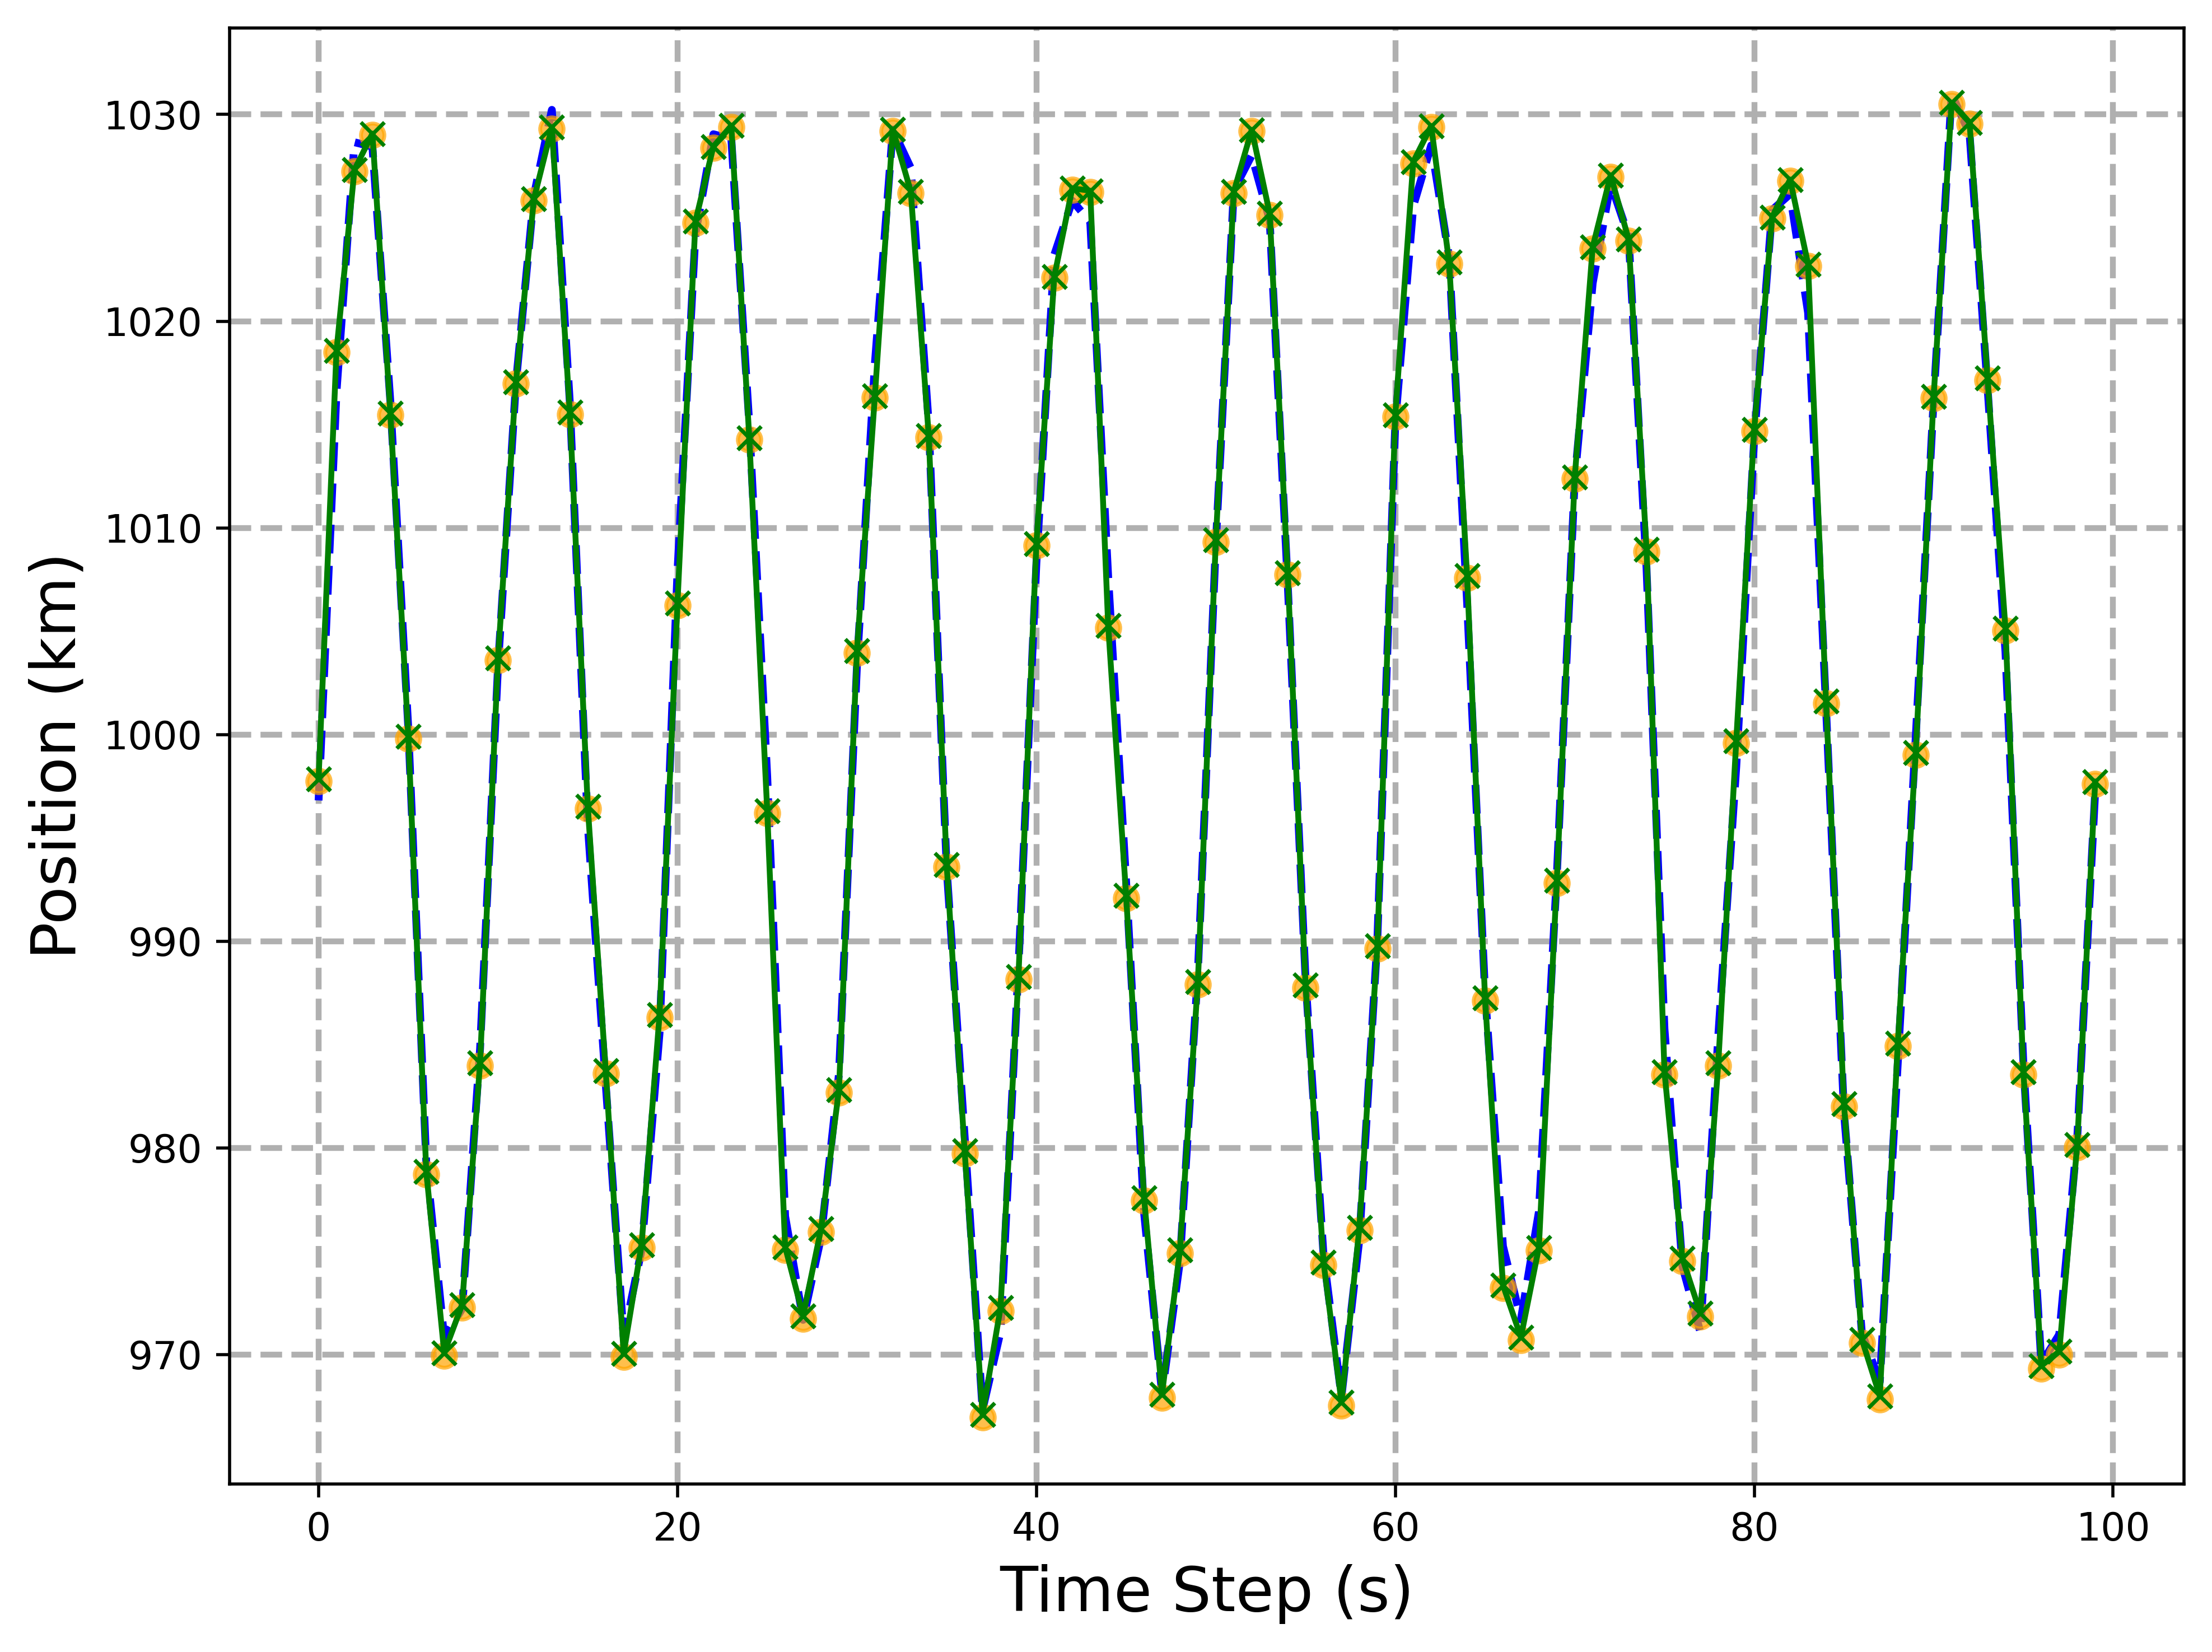

In [ ]:
# Test the model
kalman_net_model.eval()
estimated_states = kalman_net_model(inputs).detach().numpy()

# Plot the results
plt.figure(figsize=(8, 6), dpi=500)
plt.plot(altitude_MEO, label='True States', linestyle='--', linewidth=2, color='blue')  # Bold lines
plt.plot(MEO_measurements, label='Measurements', marker='o', linestyle='None', color='orange', alpha=0.7)  # Transparency for clarity
plt.plot(estimated_states, label='Estimated States', marker='x', linestyle='-', linewidth=1.5, color='green')
plt.grid(True, linestyle='--', linewidth=1.5, alpha=1)  # Dotted grid lines
#plt.title('KalmanNet for State Estimation for MEO satellite', fontsize=16, fontweight='bold')
plt.xlabel('Time Step (s)', fontsize=16)
plt.ylabel('Position (km)', fontsize=16)
#plt.legend(fontsize=12, loc='best', frameon=True, shadow=True, borderpad=1)
plt.tight_layout()
plt.show()

In [ ]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(kalman_net_model.parameters(), lr=0.001)

# Convert data to PyTorch tensors
inputs = torch.tensor(GEO_measurements, dtype=torch.float32).view(-1,1)
targets = torch.tensor(altitude_GEO, dtype=torch.float32).view(-1, 1)

# Training loop
num_epochs = 10000
for epoch in range(num_epochs):
    # Forward pass
    outputs = kalman_net_model(inputs)
    loss = criterion(outputs, targets)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/10000], Loss: 201.9448
Epoch [200/10000], Loss: 1.7081
Epoch [300/10000], Loss: 0.9413
Epoch [400/10000], Loss: 0.9416
Epoch [500/10000], Loss: 0.9415
Epoch [600/10000], Loss: 0.9415
Epoch [700/10000], Loss: 0.9415
Epoch [800/10000], Loss: 0.9415
Epoch [900/10000], Loss: 0.9415
Epoch [1000/10000], Loss: 0.9415
Epoch [1100/10000], Loss: 0.9415
Epoch [1200/10000], Loss: 0.9415
Epoch [1300/10000], Loss: 0.9415
Epoch [1400/10000], Loss: 0.9415
Epoch [1500/10000], Loss: 0.9415
Epoch [1600/10000], Loss: 0.9415
Epoch [1700/10000], Loss: 0.9415
Epoch [1800/10000], Loss: 0.9415
Epoch [1900/10000], Loss: 0.9416
Epoch [2000/10000], Loss: 0.9415
Epoch [2100/10000], Loss: 0.9415
Epoch [2200/10000], Loss: 0.9415
Epoch [2300/10000], Loss: 0.9415
Epoch [2400/10000], Loss: 0.9415
Epoch [2500/10000], Loss: 0.9415
Epoch [2600/10000], Loss: 0.9415
Epoch [2700/10000], Loss: 0.9415
Epoch [2800/10000], Loss: 0.9415
Epoch [2900/10000], Loss: 0.9415
Epoch [3000/10000], Loss: 0.9415
Epoch [3100/10000

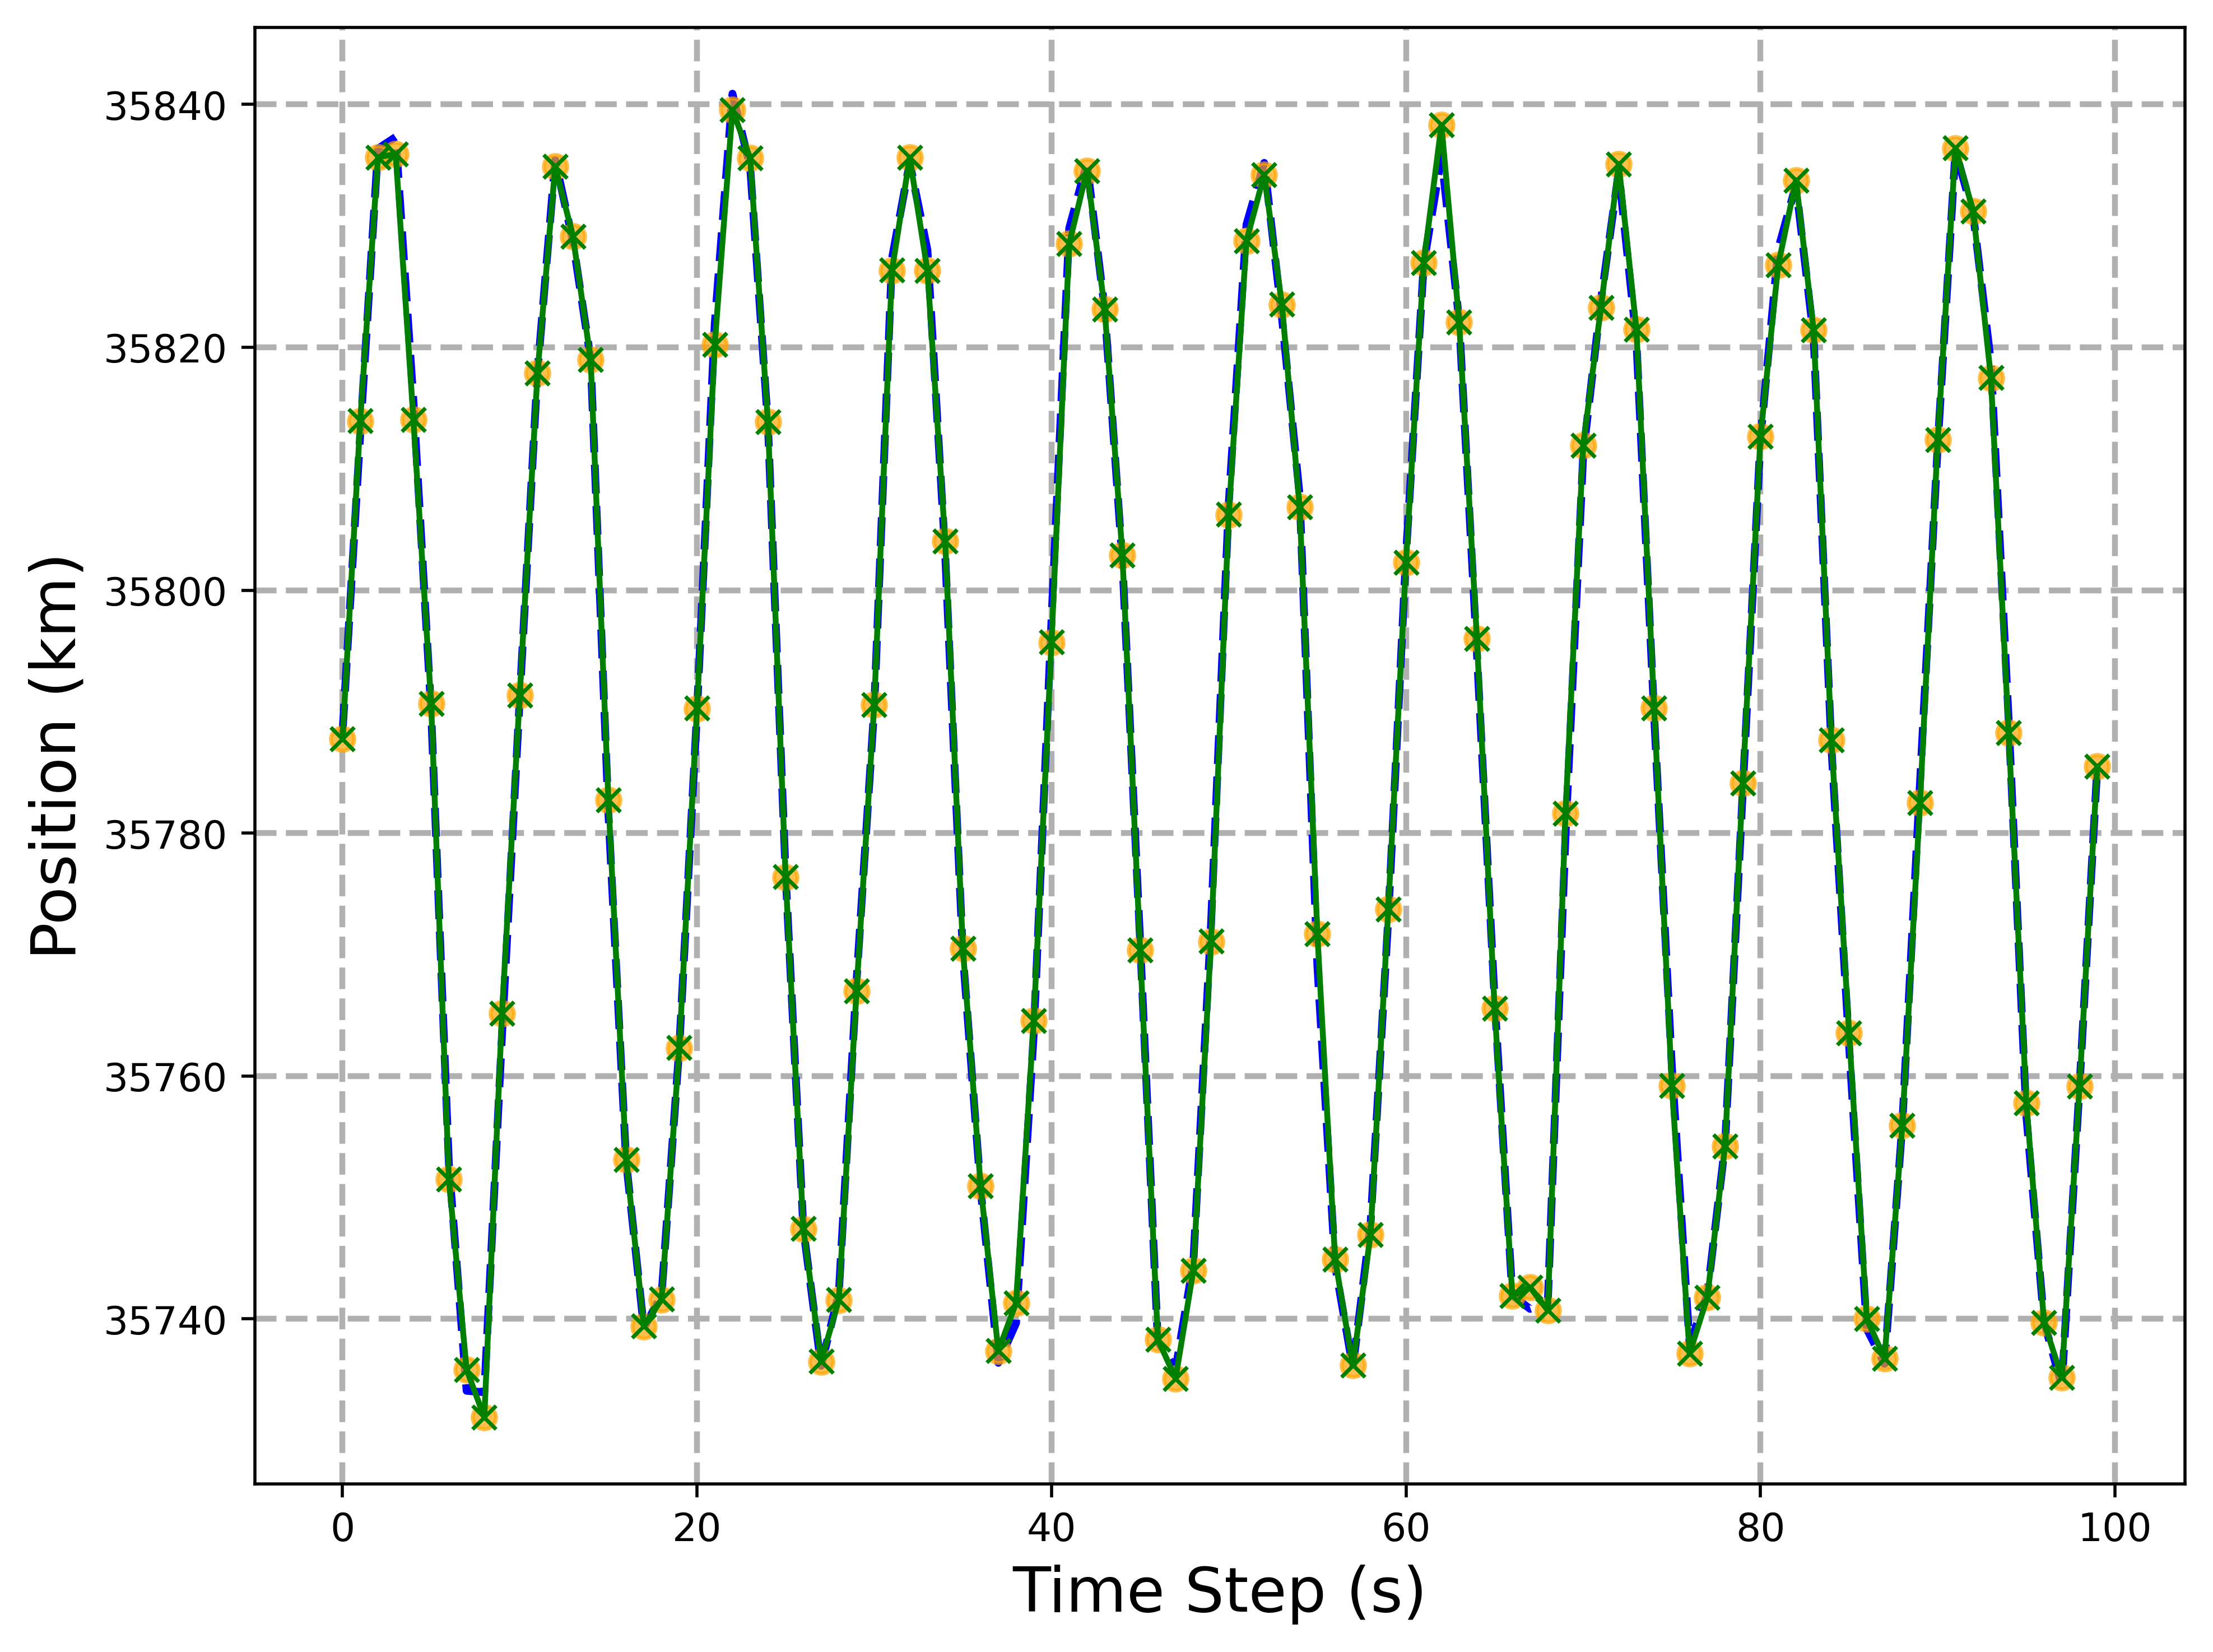

In [ ]:
# Test the model
kalman_net_model.eval()
estimated_states = kalman_net_model(inputs).detach().numpy()

# Plot the results
plt.figure(figsize=(8, 6), dpi=500)
plt.plot(altitude_GEO, label='True States', linestyle='--', linewidth=2, color='blue')  # Bold lines
plt.plot(GEO_measurements, label='Measurements', marker='o', linestyle='None', color='orange', alpha=0.7)  # Transparency for clarity
plt.plot(estimated_states, label='Estimated States', marker='x', linestyle='-', linewidth=1.5, color='green')
plt.grid(True, linestyle='--', linewidth=1.5, alpha=1)  # Dotted grid lines
#plt.title('KalmanNet for State Estimation for MEO satellite', fontsize=16, fontweight='bold')
plt.xlabel('Time Step (s)', fontsize=16)
plt.ylabel('Position (km)', fontsize=16)
#plt.legend(fontsize=12, loc='best', frameon=True, shadow=True, borderpad=1)
plt.tight_layout()
plt.show()

In [ ]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

estimator = Estimator()

Now a synthetic dataset is created for testing and training purposes, simulating measurements and true states with added noise. The data is preprocessed and visualized to understand its structure.

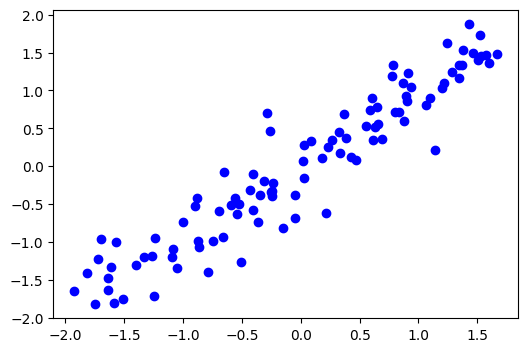

In [ ]:
num_samples = 100  # Number of samples
eps = 1  # Noise level
lb, ub = 0, 10  # Lower and upper bounds

# Creating the dataset similar to the second one
true_states = np.linspace(lb, ub, num=num_samples) + 0.5 * np.random.normal(size=num_samples)
measurements = true_states + eps * np.random.normal(size=num_samples)

# Splitting the dataset into data and labels
X = measurements.reshape(num_samples, 1)  # Features
y = true_states.reshape(num_samples, 1)   # Labels

from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)

plt.plot(X, y, "bo")
plt.show()

This section builds a Quantum Neural Network (QNN) and integrates it with a Kalman Filter-inspired Recursive Update mechanism for state prediction and correction.

1. QNN Construction:
Feature Map: Encodes classical input data as quantum states.
Ansatz: Trainable quantum circuit for parameter optimization.
EstimatorQNN: Computes expectation values of the circuit for regression tasks.
2. Neural Network Regressor:
Wraps the QNN with a squared-error loss function and optimizes using the COBYLA optimizer.
3. Quantum Kalman Filter (QKF):
Combines QNN predictions with Kalman filter logic for recursive state estimation:
Predicts states using the QNN regressor.
Corrects predictions with Kalman Gain (
𝐾
K) based on measurement noise (
𝑅
R) and process noise (
𝑄
Q).
4. Training and Prediction:
Trains the QNN on scaled inputs and outputs.
Applies recursive updates to improve state estimates.
5. Reverse Normalization:
Transforms predicted states back to the original scale for comparison with true values.
This hybrid quantum-classical model leverages QNN for enhanced prediction accuracy and the Kalman filter for robust state correction.

In [ ]:
# construct simple feature map
param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)

# construct simple ansatz
param_y = Parameter("y")
ansatz = QuantumCircuit(1, name="vf")
ansatz.ry(param_y, 0)

# construct a circuit
qc = QNNCircuit(feature_map=feature_map, ansatz=ansatz)

# construct QNN
regression_estimator_qnn = EstimatorQNN(circuit=qc, estimator=estimator)

In [ ]:
# construct the regressor from the neural network
regressor = NeuralNetworkRegressor(
    neural_network=regression_estimator_qnn,
    loss="squared_error",
    #optimizer=L_BFGS_B(maxiter=50),
    optimizer=COBYLA(maxiter=60),
    callback=callback_graph,
)

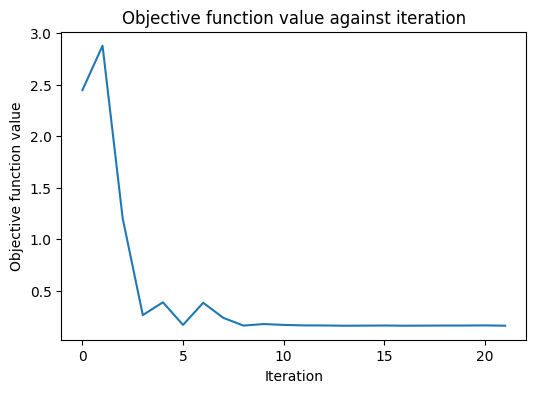

In [ ]:
# Kalman Filter-inspired Recursive Update
class QuantumKalmanFilter:
    def __init__(self, regressor, R=1.0, Q=0.1):
        self.regressor = regressor
        self.R = R  # Measurement noise covariance
        self.Q = Q  # Process noise covariance
        self.P = 1.0  # Initial estimation error covariance

    def fit(self, X, y):
        self.regressor.fit(X, y)

    def predict(self, X):
        return self.regressor.predict(X)

    def kalman_update(self, X, y):
        y_pred = self.predict(X)
        innovation = y - y_pred  # Prediction error
        K = self.P / (self.P + self.R)  # Kalman gain
        self.P = (1 - K) * self.P + self.Q  # Update error covariance
        return y_pred + K * innovation  # Corrected state

# Train the QKNN
kalman_qknn = QuantumKalmanFilter(regressor)
kalman_qknn.fit(X, y)

# Predict states
estimated_states = kalman_qknn.kalman_update(X, y)

# Reverse normalization for visualization
true_states = scaler_y.inverse_transform(y)
estimated_states = scaler_y.inverse_transform(estimated_states)

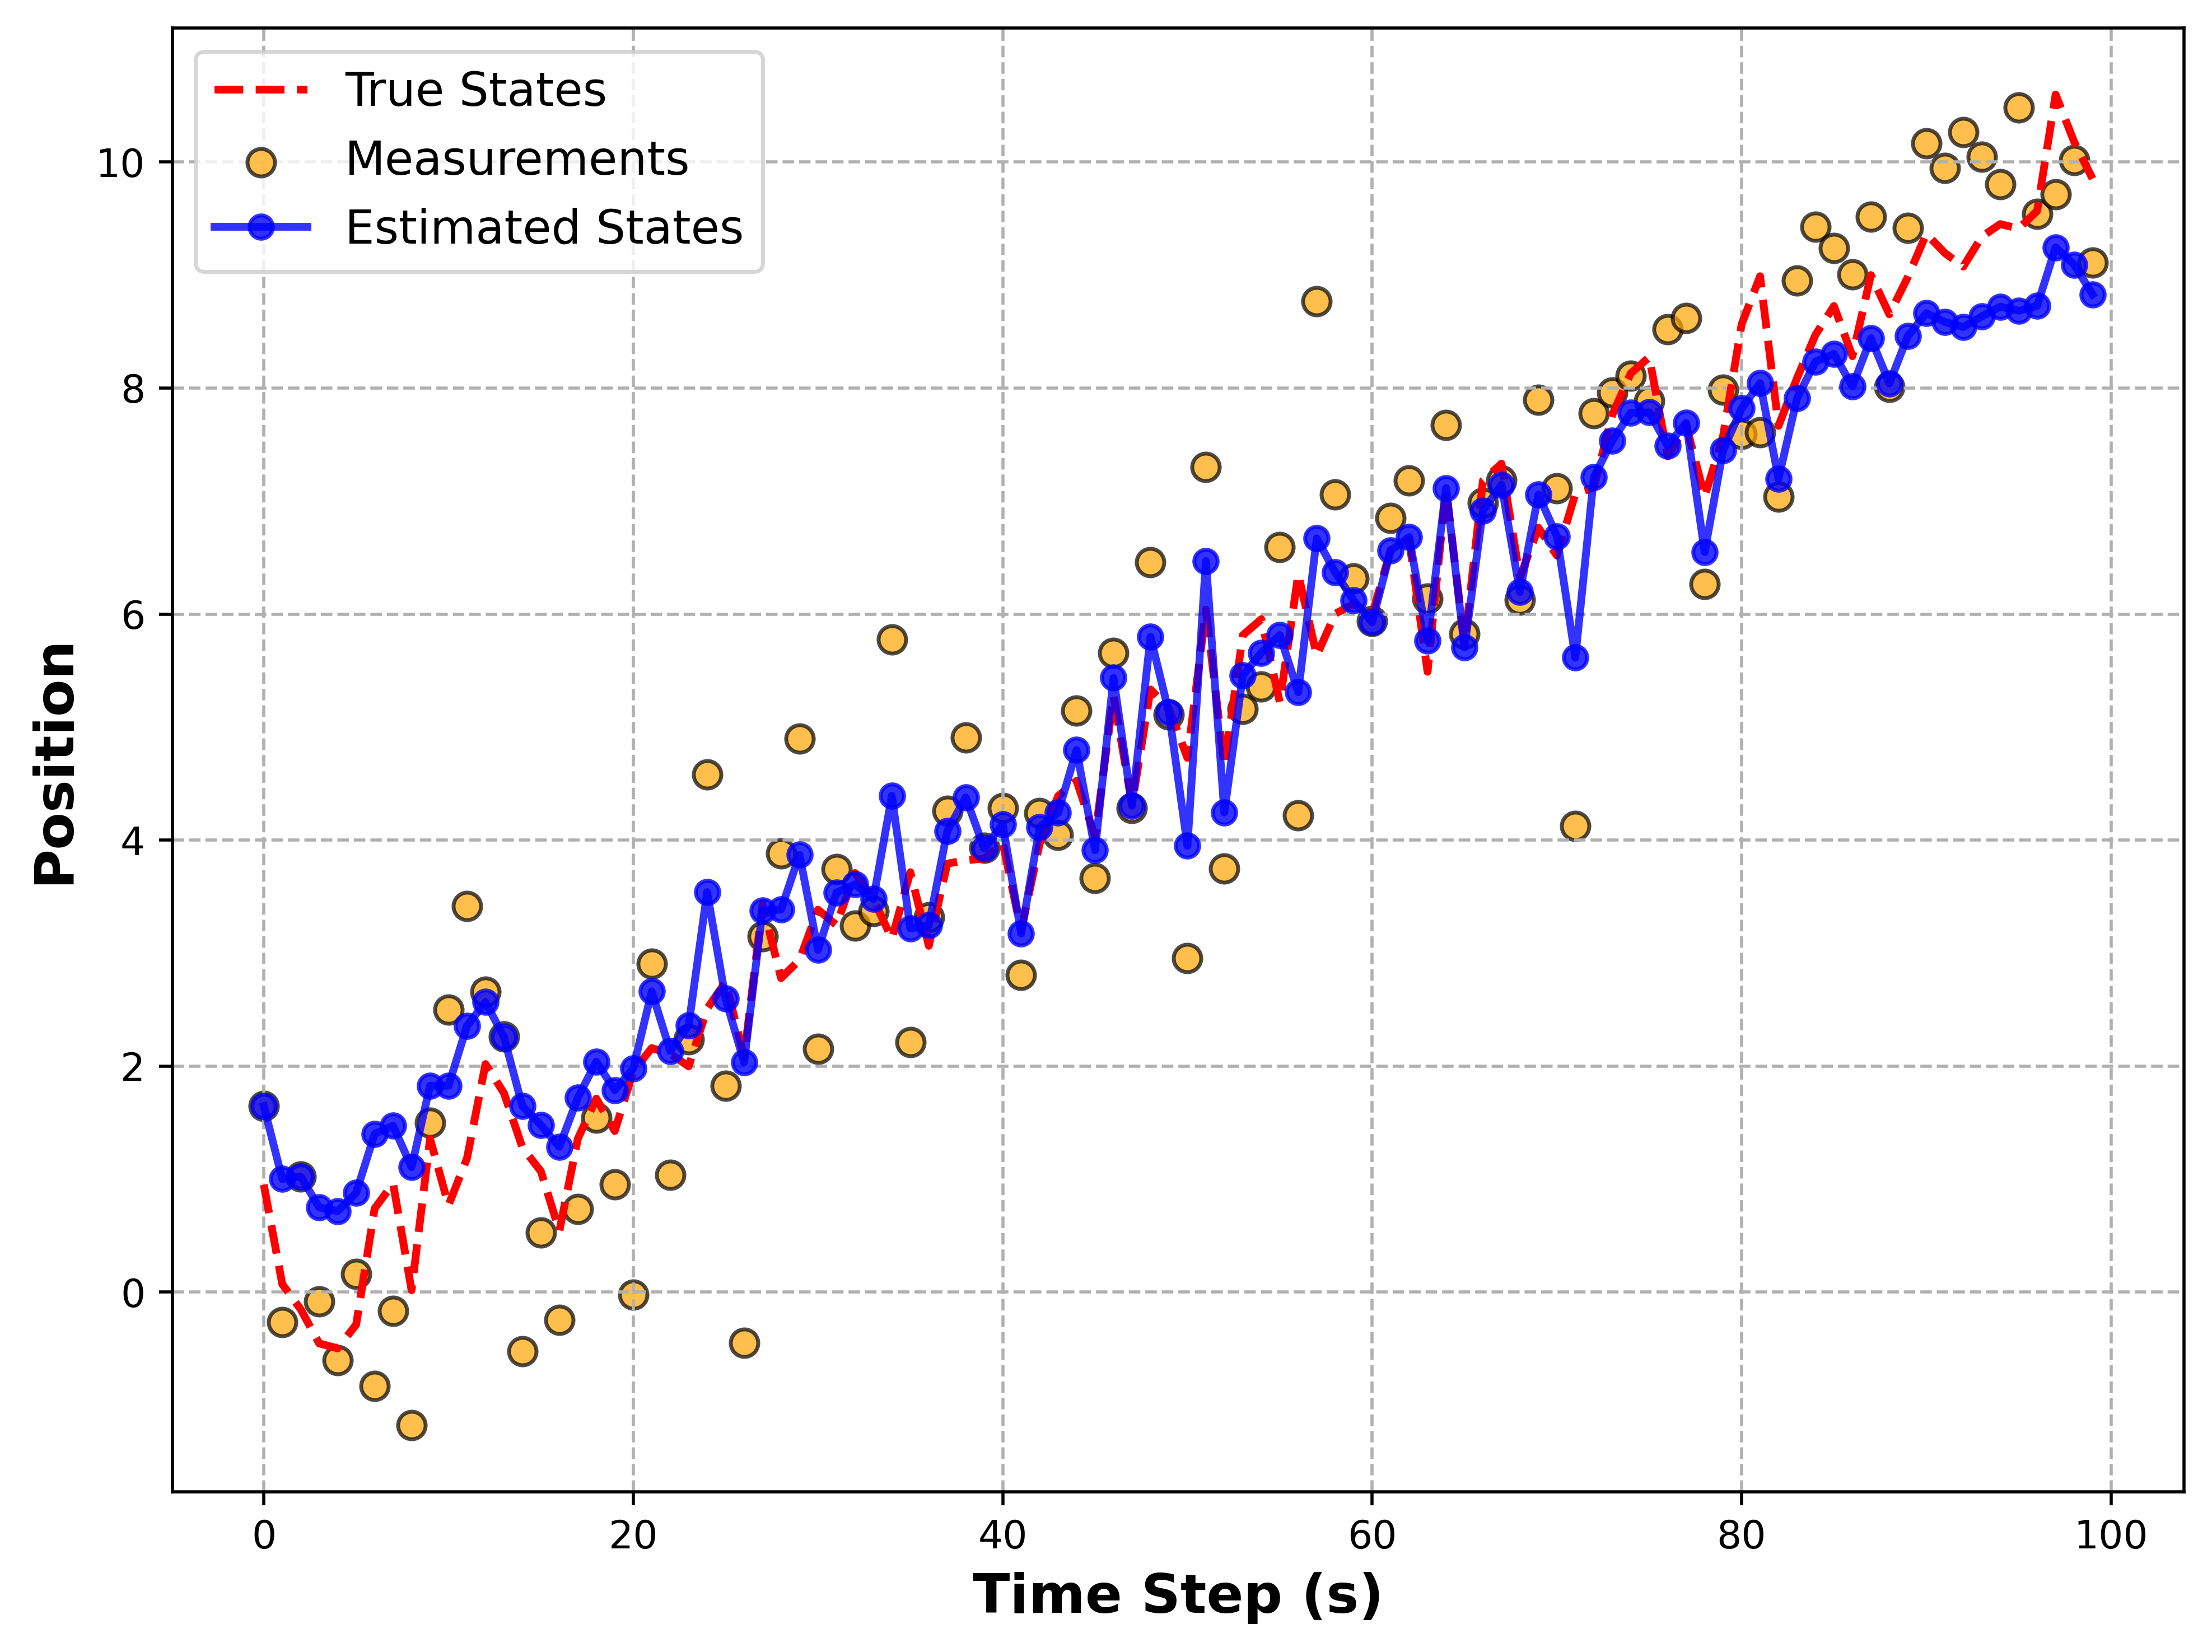

In [ ]:
# Plot results
time_steps = range(num_samples)
plt.figure(figsize=(8, 6), dpi=500)

# Plot true states
plt.plot(time_steps, true_states, "r--", label="True States", linewidth=2)

# Plot noisy measurements
plt.scatter(
    time_steps, measurements, c="orange", label="Measurements",
    alpha=0.7, edgecolor="k", s=50, marker="o"
)

# Plot estimated states
plt.plot(
    time_steps, estimated_states, "b-", label="Estimated States",
    linewidth=2, marker="o", markersize=6, alpha=0.8
)

# Add labels, title, and legend
plt.xlabel("Time Step (s)", fontsize=14, fontweight="bold")
plt.ylabel("Position", fontsize=14, fontweight="bold")
#plt.title("Quantum Kalman Neural Network for State Estimation", fontsize=16, fontweight="bold")
plt.legend(fontsize=12, loc="best", frameon=True)

# Add grid and adjust axis limits
plt.grid(True, linestyle="--", alpha=1)
#plt.xlim([0, num_samples - 1])
#plt.ylim([min(true_states) - 1, max(true_states) + 1])

# Highlight the plot
plt.tight_layout()
plt.show()

Now we implement the Quantum Kalman Filter (QKNN) for satellite altitude estimation (LEO, MEO, GEO). It normalizes data, defines a quantum feature map and ansatz, and sets up a quantum neural network (QNN) for regression. A Quantum Kalman Filter is then initialized and trained on the measurements, with Kalman updates used to estimate satellite states. Finally, the results are plotted, comparing true states, measurements, and estimated states for each satellite.

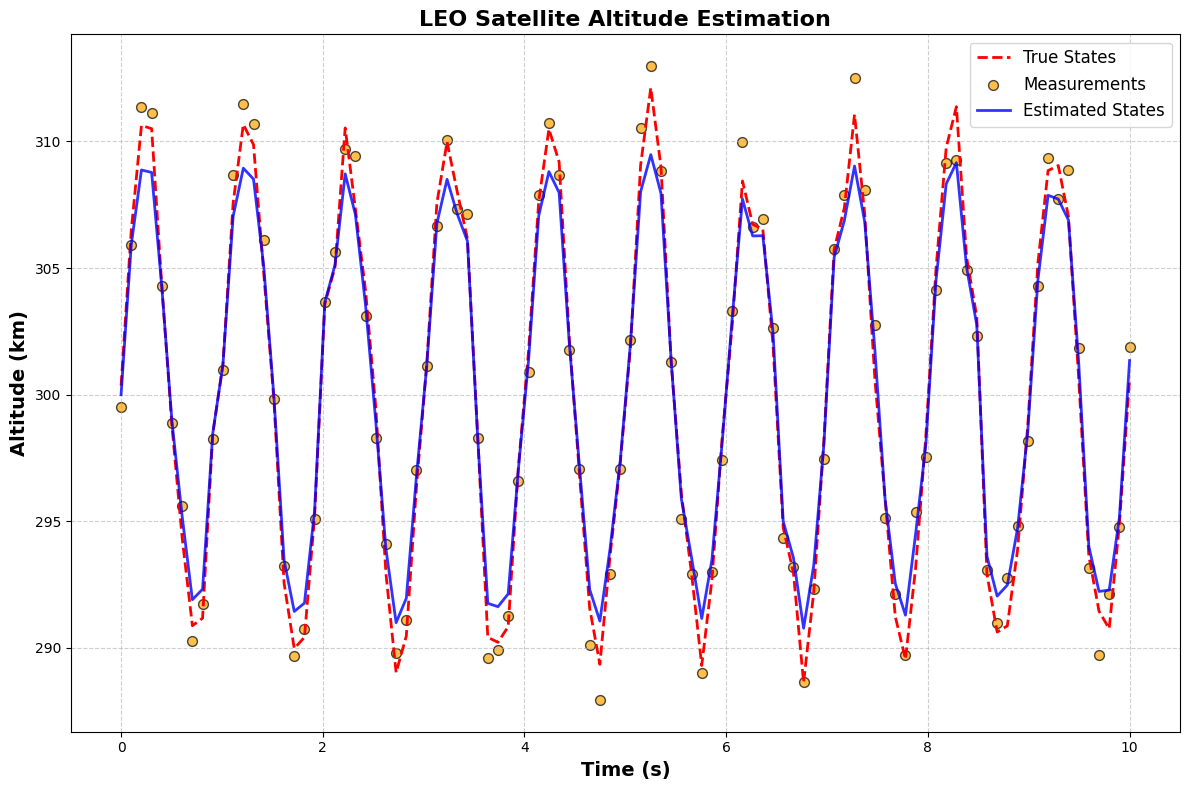

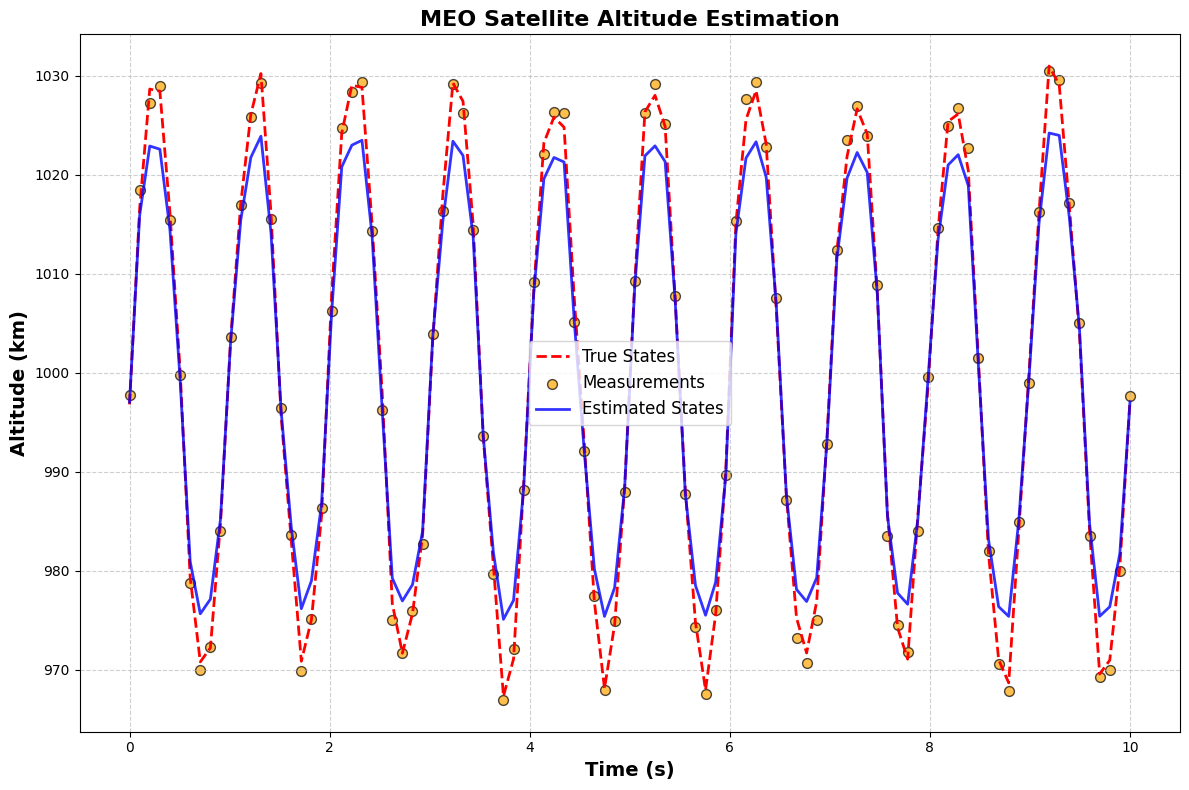

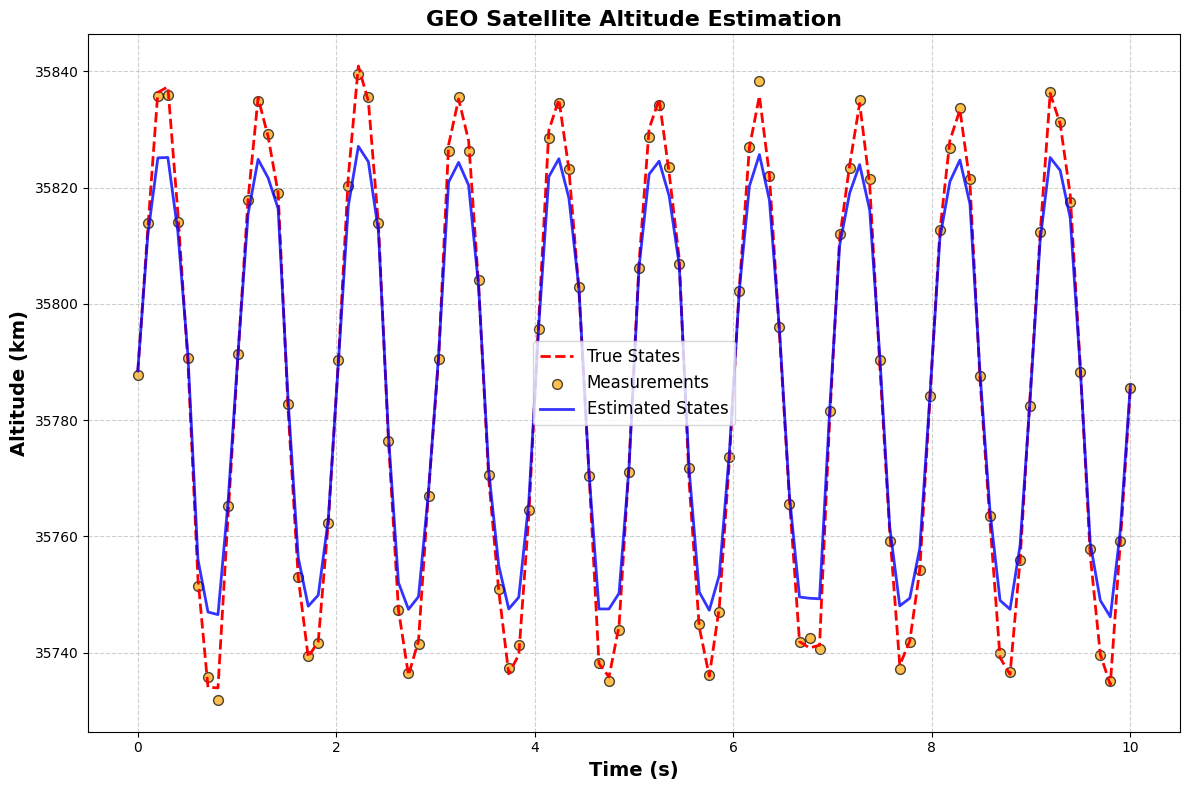

In [ ]:
def train_qknn(measurements, altitudes, R=1.0, Q=0.1):
    # Normalize the data
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X = scaler_X.fit_transform(measurements.reshape(-1, 1))
    y = scaler_y.fit_transform(altitudes.reshape(-1, 1))

    # Define Quantum Feature Map
    param_x = Parameter("x")
    feature_map = QuantumCircuit(1, name="FeatureMap")
    feature_map.ry(param_x, 0)

    # Define Quantum Ansatz
    param_y = Parameter("y")
    ansatz = QuantumCircuit(1, name="Ansatz")
    ansatz.ry(param_y, 0)

    # construct a circuit
    qc = QNNCircuit(feature_map=feature_map, ansatz=ansatz)

    # construct QNN
    regression_estimator_qnn = EstimatorQNN(circuit=qc, estimator=estimator)

    # Define regressor
    regressor = NeuralNetworkRegressor(
        neural_network=regression_estimator_qnn,
        loss="squared_error",
        optimizer=COBYLA(maxiter=50),
        callback=callback_graph
    )
    # Initialize Quantum Kalman Filter
    qkf = QuantumKalmanFilter(regressor, R=R, Q=Q)
    # Fit the QNN
    qkf.fit(X, y)
    # Perform Kalman updates
    estimated_states = qkf.kalman_update(X, y)
    # Reverse normalization
    estimated_states = scaler_y.inverse_transform(estimated_states)
    return estimated_states

# Train QKNN with Kalman updates for each satellite
LEO_estimated = train_qknn(LEO_measurements, altitude_LEO, R=1.0, Q=0.1)
MEO_estimated = train_qknn(MEO_measurements, altitude_MEO, R=2.0, Q=0.2)
GEO_estimated = train_qknn(GEO_measurements, altitude_GEO, R=3.0, Q=0.3)

# Plot results for each satellite
def plot_satellite_results(time, true_states, measurements, estimated_states, title):
    plt.figure(figsize=(12, 8))
    plt.plot(time, true_states, "r--", label="True States", linewidth=2)
    plt.scatter(time, measurements, c="orange", label="Measurements", alpha=0.7, edgecolor="k", s=50)
    plt.plot(time, estimated_states, "b-", label="Estimated States", linewidth=2, alpha=0.8)
    plt.xlabel("Time (s)", fontsize=14, fontweight="bold")
    plt.ylabel("Altitude (km)", fontsize=14, fontweight="bold")
    plt.title(title, fontsize=16, fontweight="bold")
    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

# Plot results for LEO, MEO, and GEO satellites
plot_satellite_results(time_LEO, altitude_LEO, LEO_measurements, LEO_estimated, "LEO Satellite Altitude Estimation")
plot_satellite_results(time_MEO, altitude_MEO, MEO_measurements, MEO_estimated, "MEO Satellite Altitude Estimation")
plot_satellite_results(time_GEO, altitude_GEO, GEO_measurements, GEO_estimated, "GEO Satellite Altitude Estimation")

Finally we plot the MSE loss of the VQR for 5 runs

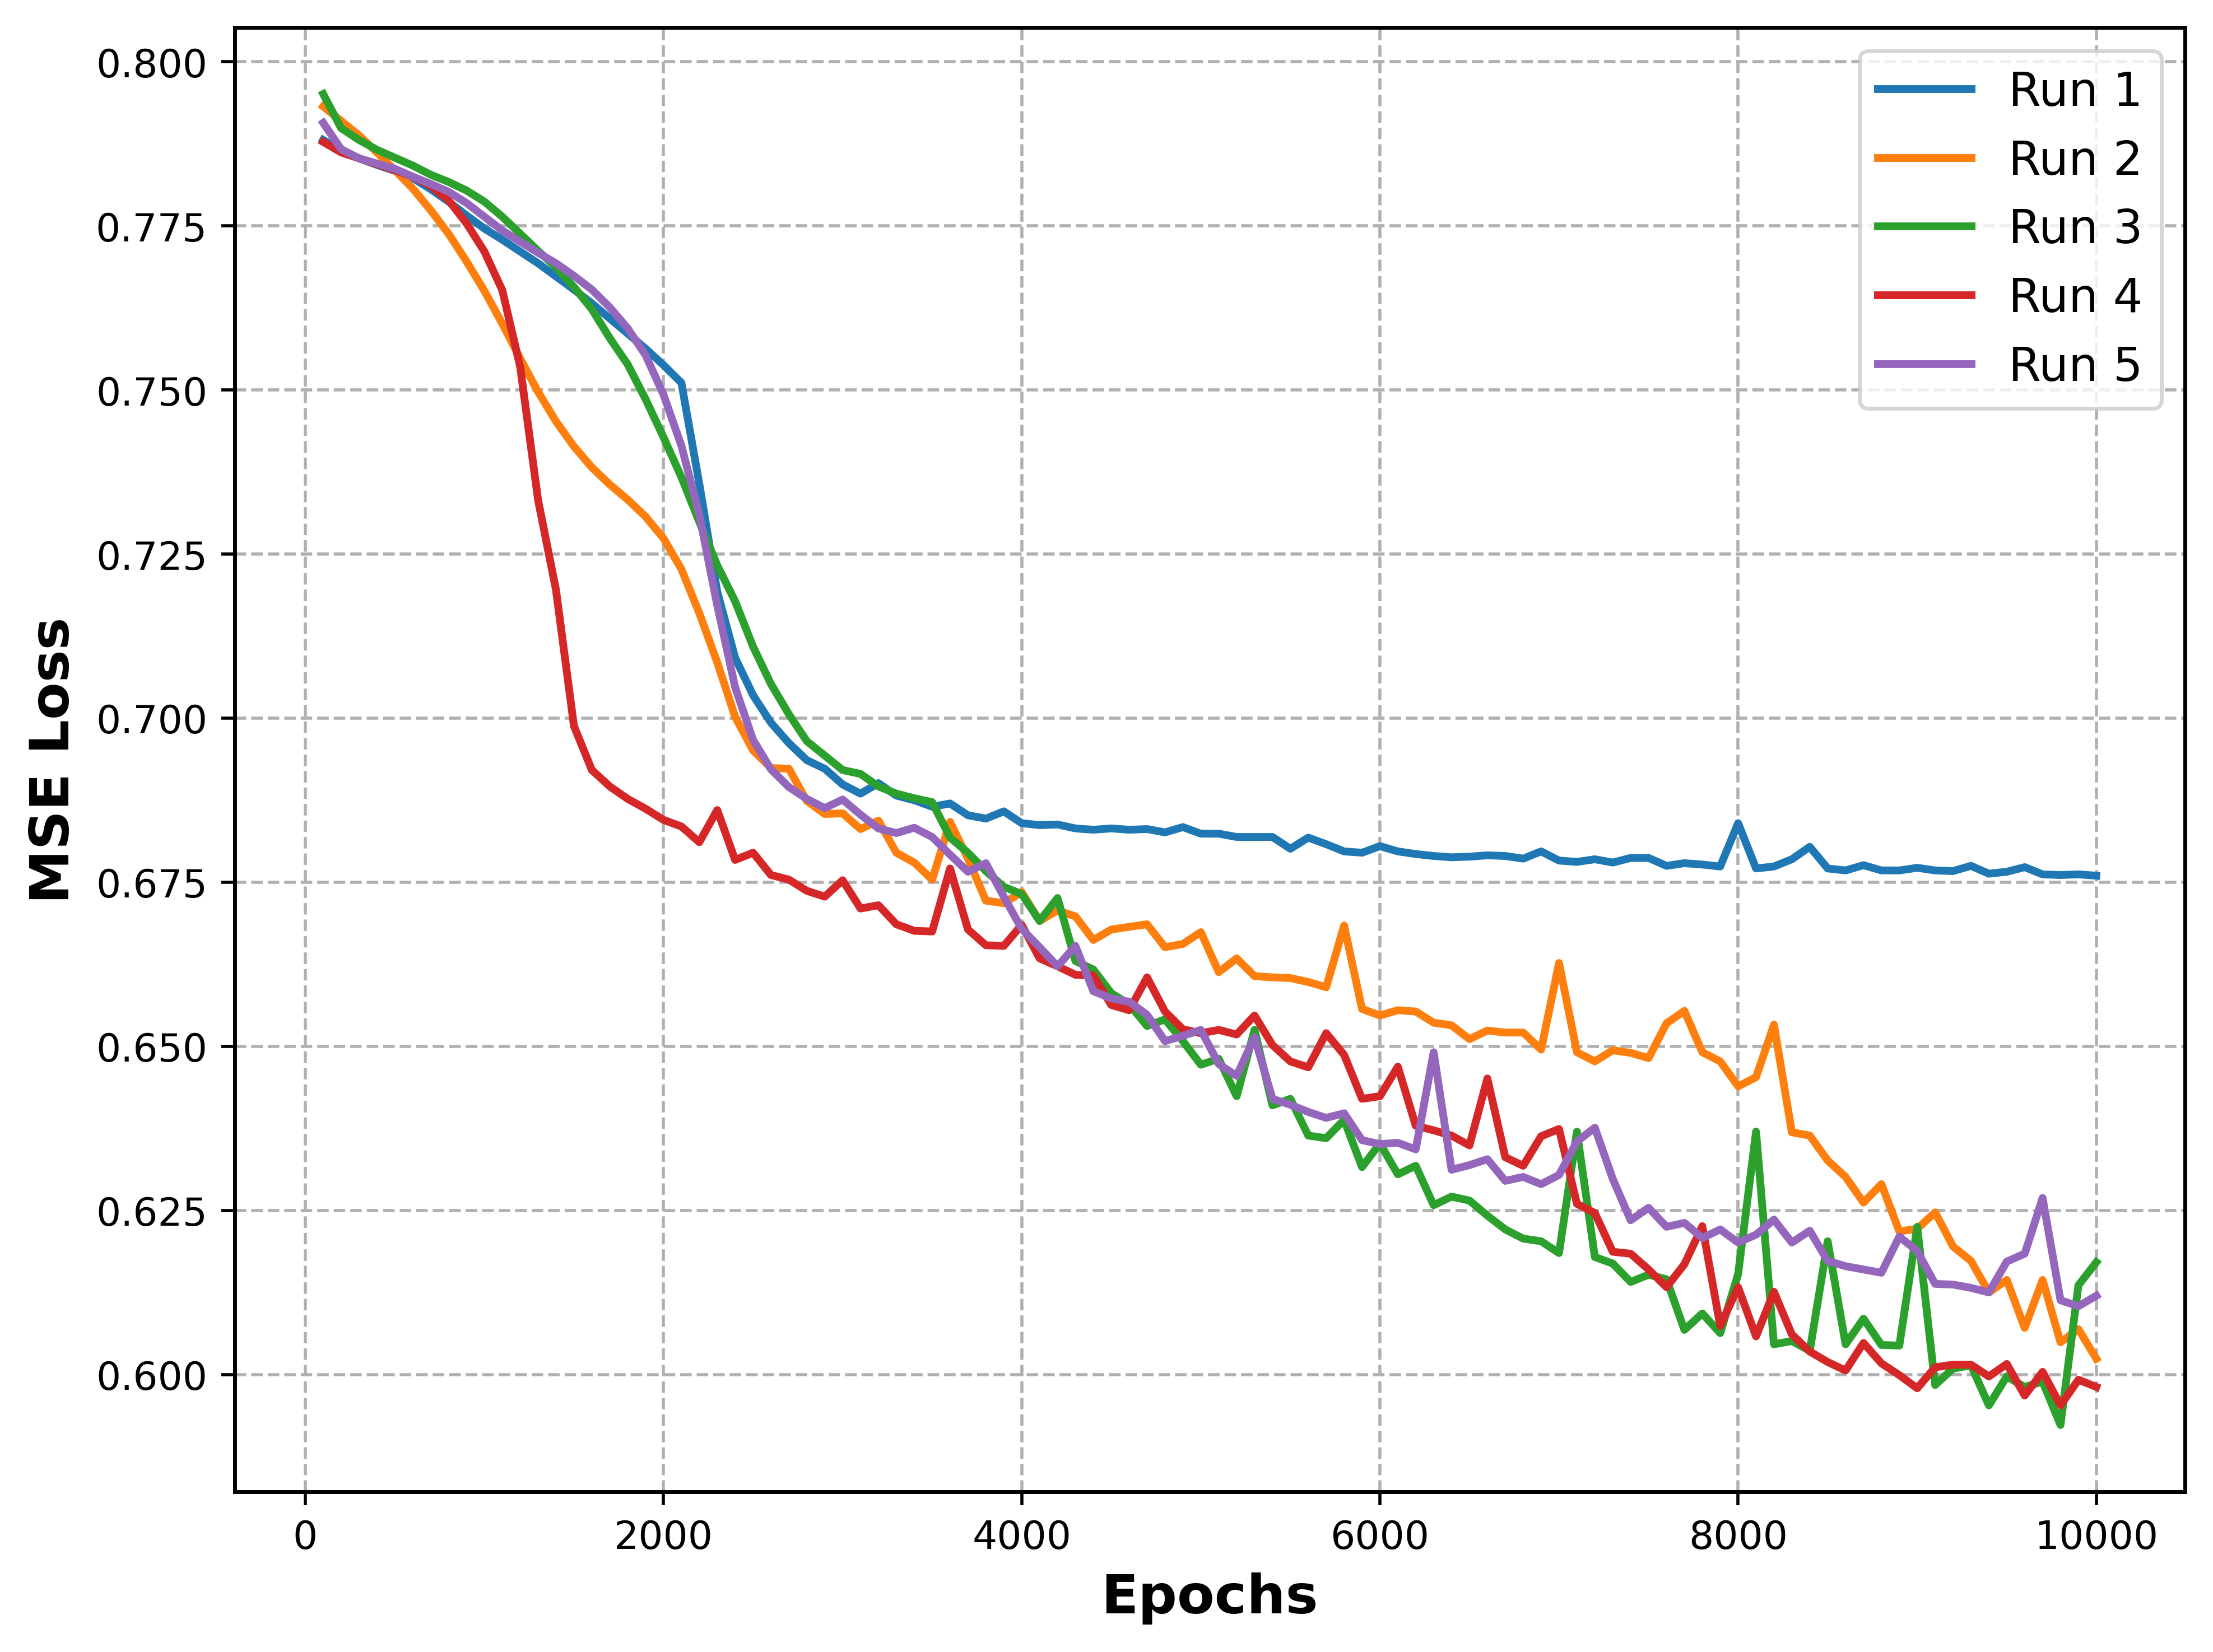

In [ ]:
# Data for the five runs
data1 = np.array([
    [100, 0.7881], [200, 0.7865], [300, 0.7853], [400, 0.7843], [500, 0.7834],
    [600, 0.7823], [700, 0.7806], [800, 0.7787], [900, 0.7766], [1000, 0.7746],
    [1100, 0.7729], [1200, 0.7711], [1300, 0.7693], [1400, 0.7673], [1500, 0.7653],
    [1600, 0.7632], [1700, 0.7609], [1800, 0.7586], [1900, 0.7563], [2000, 0.7538],
    [2100, 0.7511], [2200, 0.7357], [2300, 0.7193], [2400, 0.7092], [2500, 0.7035],
    [2600, 0.6993], [2700, 0.6962], [2800, 0.6936], [2900, 0.6923], [3000, 0.6899],
    [3100, 0.6885], [3200, 0.6901], [3300, 0.6882], [3400, 0.6875], [3500, 0.6865],
    [3600, 0.6870], [3700, 0.6852], [3800, 0.6847], [3900, 0.6858], [4000, 0.6840],
    [4100, 0.6837], [4200, 0.6838], [4300, 0.6832], [4400, 0.6830], [4500, 0.6832],
    [4600, 0.6830], [4700, 0.6831], [4800, 0.6826], [4900, 0.6834], [5000, 0.6824],
    [5100, 0.6824], [5200, 0.6819], [5300, 0.6819], [5400, 0.6819], [5500, 0.6801],
    [5600, 0.6818], [5700, 0.6808], [5800, 0.6797], [5900, 0.6795], [6000, 0.6805],
    [6100, 0.6797], [6200, 0.6793], [6300, 0.6790], [6400, 0.6788], [6500, 0.6789],
    [6600, 0.6791], [6700, 0.6790], [6800, 0.6786], [6900, 0.6797], [7000, 0.6783],
    [7100, 0.6781], [7200, 0.6785], [7300, 0.6780], [7400, 0.6787], [7500, 0.6787],
    [7600, 0.6775], [7700, 0.6779], [7800, 0.6777], [7900, 0.6774], [8000, 0.6840],
    [8100, 0.6771], [8200, 0.6774], [8300, 0.6785], [8400, 0.6804], [8500, 0.6771],
    [8600, 0.6768], [8700, 0.6776], [8800, 0.6768], [8900, 0.6768], [9000, 0.6772],
    [9100, 0.6768], [9200, 0.6767], [9300, 0.6775], [9400, 0.6763], [9500, 0.6766],
    [9600, 0.6773], [9700, 0.6762], [9800, 0.6761], [9900, 0.6762], [10000, 0.6760],
])

data2 = np.array([
    [100, 0.7932], [200, 0.7910], [300, 0.7888], [400, 0.7862], [500, 0.7835],
    [600, 0.7807], [700, 0.7774], [800, 0.7738], [900, 0.7696], [1000, 0.7651],
    [1100, 0.7601], [1200, 0.7548], [1300, 0.7497], [1400, 0.7452], [1500, 0.7414],
    [1600, 0.7382], [1700, 0.7356], [1800, 0.7333], [1900, 0.7307], [2000, 0.7274],
    [2100, 0.7227], [2200, 0.7160], [2300, 0.7085], [2400, 0.7002], [2500, 0.6951],
    [2600, 0.6924], [2700, 0.6923], [2800, 0.6874], [2900, 0.6854], [3000, 0.6855],
    [3100, 0.6831], [3200, 0.6844], [3300, 0.6795], [3400, 0.6780], [3500, 0.6754],
    [3600, 0.6842], [3700, 0.6786], [3800, 0.6722], [3900, 0.6718], [4000, 0.6735],
    [4100, 0.6691], [4200, 0.6707], [4300, 0.6698], [4400, 0.6662], [4500, 0.6678],
    [4600, 0.6682], [4700, 0.6686], [4800, 0.6651], [4900, 0.6656], [5000, 0.6674],
    [5100, 0.6613], [5200, 0.6634], [5300, 0.6607], [5400, 0.6605], [5500, 0.6604],
    [5600, 0.6598], [5700, 0.6590], [5800, 0.6684], [5900, 0.6557], [6000, 0.6547],
    [6100, 0.6555], [6200, 0.6553], [6300, 0.6536], [6400, 0.6532], [6500, 0.6511],
    [6600, 0.6524], [6700, 0.6521], [6800, 0.6521], [6900, 0.6495], [7000, 0.6627],
    [7100, 0.6491], [7200, 0.6477], [7300, 0.6494], [7400, 0.6490], [7500, 0.6482],
    [7600, 0.6535], [7700, 0.6554], [7800, 0.6491], [7900, 0.6477], [8000, 0.6439],
    [8100, 0.6453], [8200, 0.6533], [8300, 0.6369], [8400, 0.6364], [8500, 0.6326],
    [8600, 0.6301], [8700, 0.6262], [8800, 0.6290], [8900, 0.6218], [9000, 0.6222],
    [9100, 0.6247], [9200, 0.6195], [9300, 0.6173], [9400, 0.6125], [9500, 0.6144],
    [9600, 0.6071], [9700, 0.6144], [9800, 0.6049], [9900, 0.6069], [10000, 0.6024],
])

data3 = np.array([
    [100, 0.7951], [200, 0.7899], [300, 0.7881], [400, 0.7866], [500, 0.7854],
    [600, 0.7842], [700, 0.7828], [800, 0.7817], [900, 0.7804], [1000, 0.7787],
    [1100, 0.7764], [1200, 0.7738], [1300, 0.7712], [1400, 0.7687], [1500, 0.7657],
    [1600, 0.7623], [1700, 0.7579], [1800, 0.7539], [1900, 0.7486], [2000, 0.7428],
    [2100, 0.7367], [2200, 0.7299], [2300, 0.7233], [2400, 0.7178], [2500, 0.7109],
    [2600, 0.7052], [2700, 0.7006], [2800, 0.6965], [2900, 0.6943], [3000, 0.6921],
    [3100, 0.6915], [3200, 0.6896], [3300, 0.6885], [3400, 0.6878], [3500, 0.6872],
    [3600, 0.6818], [3700, 0.6795], [3800, 0.6767], [3900, 0.6743], [4000, 0.6732],
    [4100, 0.6691], [4200, 0.6726], [4300, 0.6630], [4400, 0.6617], [4500, 0.6581],
    [4600, 0.6564], [4700, 0.6531], [4800, 0.6541], [4900, 0.6508], [5000, 0.6472],
    [5100, 0.6481], [5200, 0.6424], [5300, 0.6525], [5400, 0.6410], [5500, 0.6420],
    [5600, 0.6364], [5700, 0.6360], [5800, 0.6388], [5900, 0.6316], [6000, 0.6352],
    [6100, 0.6305], [6200, 0.6318], [6300, 0.6258], [6400, 0.6271], [6500, 0.6265],
    [6600, 0.6242], [6700, 0.6221], [6800, 0.6207], [6900, 0.6203], [7000, 0.6185],
    [7100, 0.6370], [7200, 0.6179], [7300, 0.6169], [7400, 0.6141], [7500, 0.6152],
    [7600, 0.6145], [7700, 0.6068], [7800, 0.6093], [7900, 0.6063], [8000, 0.6153],
    [8100, 0.6370], [8200, 0.6046], [8300, 0.6051], [8400, 0.6036], [8500, 0.6203],
    [8600, 0.6046], [8700, 0.6085], [8800, 0.6045], [8900, 0.6044], [9000, 0.6225],
    [9100, 0.5984], [9200, 0.6009], [9300, 0.6014], [9400, 0.5953], [9500, 0.5997],
    [9600, 0.5981], [9700, 0.5989], [9800, 0.5923], [9900, 0.6136], [10000, 0.6171],
])

data4 = np.array([
    [100, 0.7878], [200, 0.7862], [300, 0.7853], [400, 0.7844], [500, 0.7835],
    [600, 0.7825], [700, 0.7811], [800, 0.7789], [900, 0.7754], [1000, 0.7711],
    [1100, 0.7652], [1200, 0.7535], [1300, 0.7332], [1400, 0.7195], [1500, 0.6988],
    [1600, 0.6921], [1700, 0.6896], [1800, 0.6877], [1900, 0.6862], [2000, 0.6845],
    [2100, 0.6835], [2200, 0.6811], [2300, 0.6860], [2400, 0.6784], [2500, 0.6795],
    [2600, 0.6761], [2700, 0.6754], [2800, 0.6737], [2900, 0.6728], [3000, 0.6753],
    [3100, 0.6710], [3200, 0.6715], [3300, 0.6686], [3400, 0.6676], [3500, 0.6675],
    [3600, 0.6771], [3700, 0.6678], [3800, 0.6654], [3900, 0.6653], [4000, 0.6685],
    [4100, 0.6634], [4200, 0.6622], [4300, 0.6609], [4400, 0.6608], [4500, 0.6563],
    [4600, 0.6555], [4700, 0.6605], [4800, 0.6553], [4900, 0.6526], [5000, 0.6520],
    [5100, 0.6525], [5200, 0.6518], [5300, 0.6547], [5400, 0.6502], [5500, 0.6477],
    [5600, 0.6468], [5700, 0.6520], [5800, 0.6487], [5900, 0.6420], [6000, 0.6424],
    [6100, 0.6469], [6200, 0.6379], [6300, 0.6372], [6400, 0.6364], [6500, 0.6349],
    [6600, 0.6451], [6700, 0.6331], [6800, 0.6318], [6900, 0.6363], [7000, 0.6374],
    [7100, 0.6260], [7200, 0.6246], [7300, 0.6187], [7400, 0.6184], [7500, 0.6160],
    [7600, 0.6133], [7700, 0.6168], [7800, 0.6226], [7900, 0.6074], [8000, 0.6133],
    [8100, 0.6058], [8200, 0.6126], [8300, 0.6061], [8400, 0.6035], [8500, 0.6019],
    [8600, 0.6006], [8700, 0.6048], [8800, 0.6017], [8900, 0.5999], [9000, 0.5979],
    [9100, 0.6011], [9200, 0.6015], [9300, 0.6015], [9400, 0.5997], [9500, 0.6016],
    [9600, 0.5968], [9700, 0.6004], [9800, 0.5953], [9900, 0.5992], [10000, 0.5981],
])

data5 = np.array([
    [100, 0.7907], [200, 0.7867], [300, 0.7853], [400, 0.7845], [500, 0.7837],
    [600, 0.7825], [700, 0.7814], [800, 0.7802], [900, 0.7785], [1000, 0.7764],
    [1100, 0.7743], [1200, 0.7726], [1300, 0.7709], [1400, 0.7693], [1500, 0.7674],
    [1600, 0.7653], [1700, 0.7626], [1800, 0.7594], [1900, 0.7553], [2000, 0.7493],
    [2100, 0.7415], [2200, 0.7310], [2300, 0.7172], [2400, 0.7047], [2500, 0.6967],
    [2600, 0.6922], [2700, 0.6895], [2800, 0.6877], [2900, 0.6863], [3000, 0.6876],
    [3100, 0.6853], [3200, 0.6832], [3300, 0.6825], [3400, 0.6833], [3500, 0.6819],
    [3600, 0.6792], [3700, 0.6766], [3800, 0.6779], [3900, 0.6728], [4000, 0.6679],
    [4100, 0.6651], [4200, 0.6622], [4300, 0.6653], [4400, 0.6584], [4500, 0.6573],
    [4600, 0.6568], [4700, 0.6548], [4800, 0.6508], [4900, 0.6516], [5000, 0.6525],
    [5100, 0.6473], [5200, 0.6455], [5300, 0.6514], [5400, 0.6420], [5500, 0.6411],
    [5600, 0.6400], [5700, 0.6391], [5800, 0.6398], [5900, 0.6357], [6000, 0.6351],
    [6100, 0.6353], [6200, 0.6343], [6300, 0.6491], [6400, 0.6312], [6500, 0.6319],
    [6600, 0.6328], [6700, 0.6295], [6800, 0.6301], [6900, 0.6290], [7000, 0.6304],
    [7100, 0.6355], [7200, 0.6376], [7300, 0.6298], [7400, 0.6235], [7500, 0.6254],
    [7600, 0.6225], [7700, 0.6231], [7800, 0.6208], [7900, 0.6221], [8000, 0.6201],
    [8100, 0.6213], [8200, 0.6236], [8300, 0.6201], [8400, 0.6219], [8500, 0.6173],
    [8600, 0.6165], [8700, 0.6160], [8800, 0.6155], [8900, 0.6210], [9000, 0.6188],
    [9100, 0.6138], [9200, 0.6137], [9300, 0.6132], [9400, 0.6125], [9500, 0.6172],
    [9600, 0.6184], [9700, 0.6269], [9800, 0.6113], [9900, 0.6104], [10000, 0.6120],
])

# Plotting the data
plt.figure(figsize=(8, 6), dpi=500)
plt.plot(data1[:, 0], data1[:, 1], label='Run 1', linewidth=2)
plt.plot(data2[:, 0], data2[:, 1], label='Run 2', linewidth=2)
plt.plot(data3[:, 0], data3[:, 1], label='Run 3', linewidth=2)
plt.plot(data4[:, 0], data4[:, 1], label='Run 4', linewidth=2)
plt.plot(data5[:, 0], data5[:, 1], label='Run 5', linewidth=2)

# Adding labels, title, legend, and grid
plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('MSE Loss', fontsize=14, fontweight='bold')
#plt.title('MSE Loss vs. Epochs', fontsize=16, fontweight='bold')
plt.legend(loc='best', fontsize=12)
plt.grid(True, linestyle='--', alpha=1)

# Thicker plot borders
ax = plt.gca()
ax.spines['top'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)

# Show the plot
plt.tight_layout()
plt.show()